In [1]:
import numpy as np
import pandas as pd
import re as re
from langdetect import detect
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from PIL import Image
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns



/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Part 1 - Simple Wordcloud

In [3]:
# read in translated + cleaned data


df_clean = pd.read_csv("18_march_df_cleaned_translated_abstracts.csv")
df_clean_no_stem = pd.read_csv("18_march_df_clean_translate_nostem.csv")
df_clean.shape



(8330, 25)

Foundations in dataset :
['Independent Research Fund Denmark' 'Carlsberg Foundation'
 'Novo Nordisk Foundation']
0                 Carlsberg Foundation
1    Independent Research Fund Denmark
2              Novo Nordisk Foundation
Name: foundation, dtype: object
Carlsberg


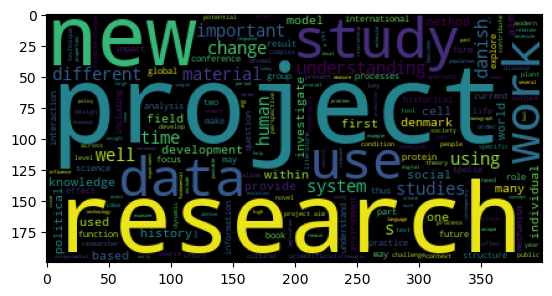

Independent Research Fund Denmark


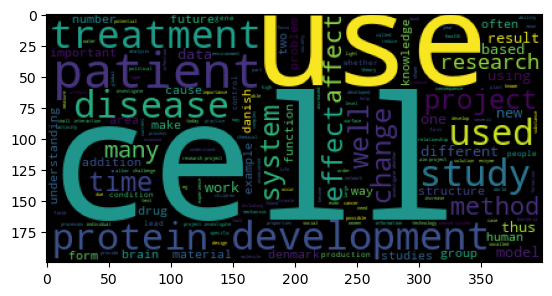

Novo Nordisk Foundation


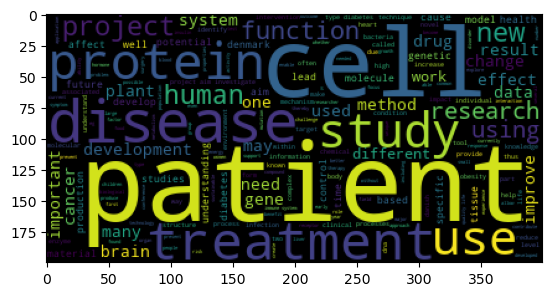

0                 Carlsberg Foundation
1    Independent Research Fund Denmark
2              Novo Nordisk Foundation
Name: foundation, dtype: object
Carlsberg


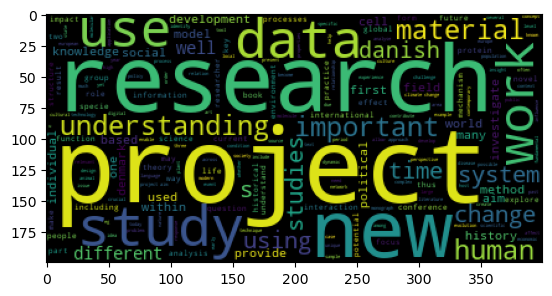

Independent Research Fund Denmark


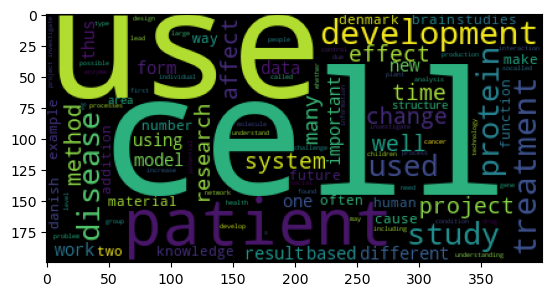

Novo Nordisk Foundation


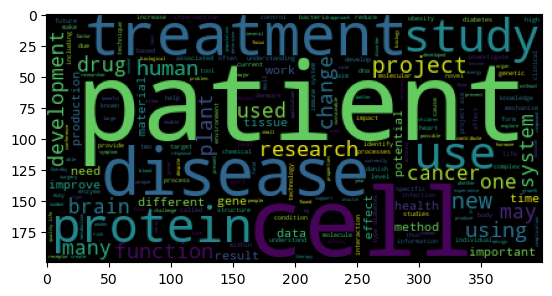

In [308]:
def wordcloud_maker(df_new):
    
    """This function prints 3 wordclouds, one for each foundation in the dataset, by aggregated text abstracts
    
    It prints the wordclouds
    """
    
    df_new.abstract.astype(str)  
    df_new.foundation.astype(str) 
    df_cleaned = df_new.dropna(subset = ["cleaned_column"]) #drop NAs
    df_grouped = df_cleaned.groupby("foundation", as_index=False).agg({"cleaned_column": " ".join})  #group by foundation and join ALL abstracts for each foundation

    print(df_grouped.foundation)
    carlsberg_text = df_grouped.cleaned_column.iloc[0]
    IDRF = df_grouped.cleaned_column.iloc[1]
    novo = df_grouped.cleaned_column.iloc[2]

    # wordclouds:
    
    print("Carlsberg")
    wc = WordCloud().generate(carlsberg_text)
    plt.imshow(wc)
    plt.show()
    
    print("Independent Research Fund Denmark")
    wc = WordCloud().generate(IDRF)
    plt.imshow(wc)
    plt.show()
    
    print("Novo Nordisk Foundation")
    wc = WordCloud().generate(novo)
    plt.imshow(wc)
    plt.show()
    
    return

print("Foundations in dataset :")
print(df_clean.foundation.unique())
wordcloud_maker(df_clean)
wordcloud_maker(df_clean_no_stem)

In [9]:
#Part 2 - PCA

In [258]:
#v optimal_list_maker

def tf_idf_transform(df_target_column, min_ins, max_ins):
    
    df_target_column = df_target_column.fillna('')
    tf = TfidfVectorizer(tokenizer=casual_tokenize, sublinear_tf=True, min_df = min_ins, max_df = max_ins, stop_words='english', norm = "l2", smooth_idf=False) #tf-idf tokenize init
    x_vector = tf.fit_transform(df_target_column)  # transform data

    
    number_of_features = x_vector.shape[1]

    
    return x_vector, number_of_features, tf


def find_variance(svd_init):
    
    cumulative_variance = np.cumsum(svd_init.explained_variance_ratio_)
    n_compon = np.argmax(cumulative_variance >= 0.9) + 1
    
    print(n_compon)
    
    return n_compon
    
    

def svd_calc(X_vector, N_features):
    
    """
    
    """

    svd = TruncatedSVD(n_components=N_features, random_state=37)
    
    svd_real_vec = svd.fit_transform(X_vector)  #pca fit_tranform vector
    
    opt_number = find_variance(svd)
    
    
    return opt_number

  
def fun_call_v1(df_c):
    
    """
    #version 1 -> reset every year, calculate TF-IDF individual for each year
    
    """
    
    
    df_c["abstract_no_nan"] = df_c.cleaned_column.fillna('')
    
    df_c = df_c.sort_values(["year"])

    years_f = sorted(df_c.year.unique())
    
    years = years_f[2:]  #only print from 2018
    
    opt_number_list = []

        
    for num, i in enumerate(years):
        
        data_mask = df_c.year == i #mask year i
        
        data = df_c[data_mask]  #resetting index + extracting year i

        X_vector, N_features, tf = tf_idf_transform(data["abstract_no_nan"], 1, 0.99)

        
        opt_number = svd_calc(X_vector, N_features)
        print(opt_number)
        
        opt_number_list.append(opt_number)
        
    return opt_number_list



def optimal_feature_number_prerun(df_i, df_clean_abstract_col):
    
    
    opt_num_of_features = []

    df_i = df_i.sort_values(["year"])

    X_vector, N_features, tf = tf_idf_transform(df_clean_abstract_col, 1, 0.99)  #tf_idf function

    df_i["year"] = df_i["year"].astype(int)
    years_f = sorted(df_i["year"].unique())
    years=years_f[2:]

    final_list = []
    for s in years:
        middle_list = []
        for num, i in enumerate(df_i["year"]):

            if s == i:
                middle_list.append(num)
        indexes = (min(middle_list), max(middle_list))
        final_list.append(indexes)

    print(final_list)

    for num, i in enumerate(final_list):

        N_features2 = X_vector[i[0]:i[1],:].shape[1]
        svd2 = TruncatedSVD(N_features2, random_state=37)
        
        svd_real_vec = svd2.fit_transform(X_vector[i[0]:i[1],:])  #pca fit_tranform vector
    
        opt_number = find_variance(svd2)
        opt_num_of_features.append(opt_number)
        
    return opt_num_of_features


def fun_call_v2(df_c):
    
    """
    #version 2 -> make tf_idf with all data and then iterate over the years 
    
    """
    
    df_sorted = df_c.sort_values(["year"])

    list2 = optimal_feature_number_prerun(df_sorted, df_sorted["abstract_no_nan"])
    #pr_found_svd_calc_pr_year(df_sorted, df_sorted["abstract_no_nan"], df_sorted["foundation"])
        
    return list2

In [19]:

df_clean["abstract_no_nan"] = df_clean.cleaned_column.fillna('')

print("Version 1")
l1 = fun_call_v1(df_clean)

Version 1
508
508
756
756
847
847
894
894
913
913
1023
1023


In [11]:
df_clean["abstract_no_nan"] = df_clean.cleaned_column.fillna('')
l2 = fun_call_v2(df_clean)

/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[(1066, 2061), (2062, 3104), (3105, 4304), (4305, 5551), (5552, 6892), (6893, 8329)]
513
760
852
900
920
1030


In [303]:
l1 = [508, 756, 847, 894, 913, 1023]
l2 = [513, 760, 852, 900, 920, 1030]

In [306]:
#v3

def tf_idf_transform(df_target_column, min_ins, max_ins):
    
    df_target_column = df_target_column.fillna('')
    tf = TfidfVectorizer(tokenizer=casual_tokenize, min_df = min_ins, max_df = max_ins, stop_words='english', norm = "l2", smooth_idf=True) #tf-idf tokenize init
    x_vector = tf.fit_transform(df_target_column)  # transform data
    number_of_features = len(tf.get_feature_names_out())
    
    print(number_of_features)
    print(tf.get_feature_names_out())
    
    return x_vector, number_of_features, tf
    

def plot_variance_and_cummulative(svd_init, n_feat):
    
    """
    
    """
    
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    explained_variance = svd_init.explained_variance_

    axes[0].plot(range(1, len(explained_variance) + 1), explained_variance * 100, marker='o', color='b')
    axes[0].set_title(f'Explained Variance for n SVD Components : {n_feat}')
    axes[0].set_xlabel('SVD Component')
    axes[0].set_ylabel('Explained Variance (%)')
    axes[0].grid(True)

    cumulative_variance = np.cumsum(svd_init.explained_variance_ratio_)

    axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, color='g')
    axes[1].set_title('Cumulative Explained Variance')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].grid(True)

    plt.tight_layout()

    plt.show()

    
    return 



def plot_time_series_svd(all_years_svd_df, all_mean_values_df, order):

    """
    Plots the SVD projections as a time series with both scatter and KDE density plots.
    """
    g = sns.FacetGrid(all_years_svd_df, col="year", col_wrap=3, height=4, sharex=True, sharey=True)
    
    
    g.map_dataframe(sns.scatterplot, x=1, y=2, hue="foundation", hue_order = order, alpha=0.3, palette="tab10")
    
    g.map_dataframe(sns.kdeplot, x=1, y=2, hue="foundation", hue_order = order, levels=3, palette="tab10", alpha=0.4, fill=False)

    for ax in g.axes.flat:
        year = ax.get_title().split('=')[-1].strip() 

        mean_year = all_mean_values_df[all_mean_values_df["year"] == int(year)]

        sns.scatterplot(data=mean_year, x=1, y=2, hue="foundation", hue_order=order,
                        palette="tab10", marker="X", s=150, edgecolor="black", linewidth=1.5, 
                        legend=False, ax=ax) 

    
    for ax in g.axes.flat:
        ax.set_xlim(-0.3, 0.3)
        ax.set_ylim(-0.3, 0.3)
    
    g.add_legend()
    plt.show()
    

def svd_calc(df_i, df_target_text_column, df_foundation_column, X_vector, N_features, opt_number):
    
    """
    
    """

    svd = TruncatedSVD(n_components=opt_number, random_state=42)
    
    svd_real_vec = svd.fit_transform(X_vector)  
    
    
    plot_variance_and_cummulative(svd, opt_number) 
    
    
    df_svd = pd.DataFrame(svd_real_vec, columns=list(range(svd_real_vec.shape[1]))) 
    
    
    n_foundation = len(df_foundation_column.unique())
    
    
    print("data shape :", df_svd.shape)
    
    svd_new_df = pd.concat([df_svd, df_foundation_column.reset_index(drop=True)], axis=1)
    mean_values = svd_new_df.groupby('foundation')[[1, 2]].mean().reset_index()
    
    order = sorted(svd_new_df.foundation.unique())
    
    return svd_new_df, mean_values, order


def fun_call_v1(df_c, l_1):
    
    """
    #version 1 -> reset every year, calculate TF-IDF individual for each year
    
    """
    
    
    df_c["abstract_no_nan"] = df_c.cleaned_column.fillna('')
    
    df_c = df_c.sort_values(["year"])

    years_f = sorted(df_c.year.unique())
    
    years = years_f[2:]  #only print from 2018
    
    opt_number_list = []
    X_vector_list = []
    N_feature_list = []
    yearly_svd_data = []
    yearly_mean_values = []
        
    for num, i in enumerate(years):
        
        data_mask = df_c.year == i #mask year i
        
        data = df_c[data_mask]  #resetting index + extracting year i

        X_vector, N_features, tf = tf_idf_transform(data["abstract_no_nan"], 1,  0.99)
        
        print("shape of dataframe : ", data.shape)
        print("Year : ", i)
        
        svd_df, m_val, order_s = svd_calc(data, data["abstract_no_nan"], data["foundation"], X_vector, N_features, l_1[num])
        svd_df["year"] = i  # Add year column for grouping later
        m_val["year"] = i
        
        yearly_svd_data.append(svd_df)
        yearly_mean_values.append(m_val)

    all_years_svd_df = pd.concat(yearly_svd_data, ignore_index=True)
    all_mean_values_df = pd.concat(yearly_mean_values, ignore_index=True)

    plot_time_series_svd(all_years_svd_df, all_mean_values_df, order_s)
        
    return


def optimal_feature_number_prerun(df_i, df_clean_abstract_col):
    

    df_i = df_i.sort_values(["year"])

    X_vector, N_features, tf = tf_idf_transform(df_clean_abstract_col, 1, 0.99)  #tf_idf function

    df_i["year"] = df_i["year"].astype(int)
    years_f = sorted(df_i["year"].unique())
    years=years_f[2:]

    final_list = []
    for s in years:
        middle_list = []
        for num, i in enumerate(df_i["year"]):

            if s == i:
                middle_list.append(num)
        indexes = (min(middle_list), max(middle_list))
        final_list.append(indexes)

    print(final_list)
        
        
    return final_list, X_vector


def svd_calc_pr_year(df, text_columns, df_foundation_column_all, optnumlist):
    """


    """

    
    final_list, X_vector = optimal_feature_number_prerun(df, text_columns)
    
    df["year"] = df["year"].astype(int)
    years_f = sorted(df.year.unique())
    years=years_f[2:]
    
    all_years_svd_data = []

    for num, i in enumerate(final_list):
        
        print(years[num])

        # 2. Truncated SVD with dimensions 90% variance explanation
        
    
        svd = TruncatedSVD(n_components=optnumlist[num], random_state=42)  #svd initialization
        svd_vec = svd.fit_transform(X_vector[i[0]:i[1],:])  #pca fit_transform vector


        plot_variance_and_cummulative(svd, optnumlist[num])  # plot function run

        df_svd = pd.DataFrame(svd_vec, columns=list(range(svd_vec.shape[1])))  # new dataframe of scaled numbers

        svd_new_df = pd.concat([df_svd, df_foundation_column_all.iloc[i[0]:i[1]].reset_index(drop=True)], axis=1)

        svd_new_df['year'] = years[num]

        all_years_svd_data.append(svd_new_df)


    all_years_svd_df = pd.concat(all_years_svd_data, ignore_index=True)
    
    order = sorted(all_years_svd_df.foundation.unique())


    g = sns.FacetGrid(all_years_svd_df, col="year", col_wrap=3, height=4, sharex=True, sharey=True)

    g.map_dataframe(sns.scatterplot, x=1, y=2, hue="foundation", hue_order = order, alpha=0.4, palette="tab10")

    g.map_dataframe(sns.kdeplot, x=1, y=2, hue="foundation", hue_order = order, levels = 3, palette="tab10", alpha=0.5, fill=False)

    for ax in g.axes.flat:

        year = ax.get_title().split(' = ')[1]
        mean_values = all_years_svd_df[all_years_svd_df['year'] == int(year)].groupby('foundation')[[1, 2]].mean().reset_index()
        order = sorted(all_years_svd_df.foundation.unique())

        sns.scatterplot(data=mean_values, x=1, y=2, hue="foundation", hue_order=order, palette="tab10", marker="X", s=150, edgecolor="black", linewidth=1.5, ax=ax, legend=False)

        ax.set_xlim(-0.3, 0.3)
        ax.set_ylim(-0.3, 0.3)
        
    g.add_legend()
    g.set_axis_labels('Component 1', 'Component 2')
    g.set_titles('Year {col_name}')

    plt.show()
    
    
    for i in order:
        
        print("Foundation :", i)
        data_mask = all_years_svd_df.foundation == i

        data = all_years_svd_df[data_mask]
        g = sns.FacetGrid(data, col="year", col_wrap=3, height=4, sharex=True, sharey=True)

        g.map_dataframe(sns.scatterplot, x=1, y=2, alpha=0.4)

        g.map_dataframe(sns.kdeplot, x=1, y=2, levels=2, alpha=0.5, fill=False)
        
        ax.set_xlim(-0.3, 0.3)
        ax.set_ylim(-0.3, 0.3)

        g.add_legend()
        g.set_axis_labels('Component 1', 'Component 2')
        g.set_titles('Year {col_name}')

        # Show the plot
        plt.show()
    return
   


def fun_call_v2(df_c, l_2):
    
    """
    #version 2 -> make tf_idf with all data and then iterate over the years 
    
    """
    
    df_sorted = df_c.sort_values(["year"])

    svd_calc_pr_year(df_sorted, df_sorted["abstract_no_nan"], df_sorted["foundation"], l_2)
        
    return

Version 1


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


10828
['0' '00005' '005' ... 'zone' 'zones' 'zurich']
shape of dataframe :  (996, 26)
Year :  2018


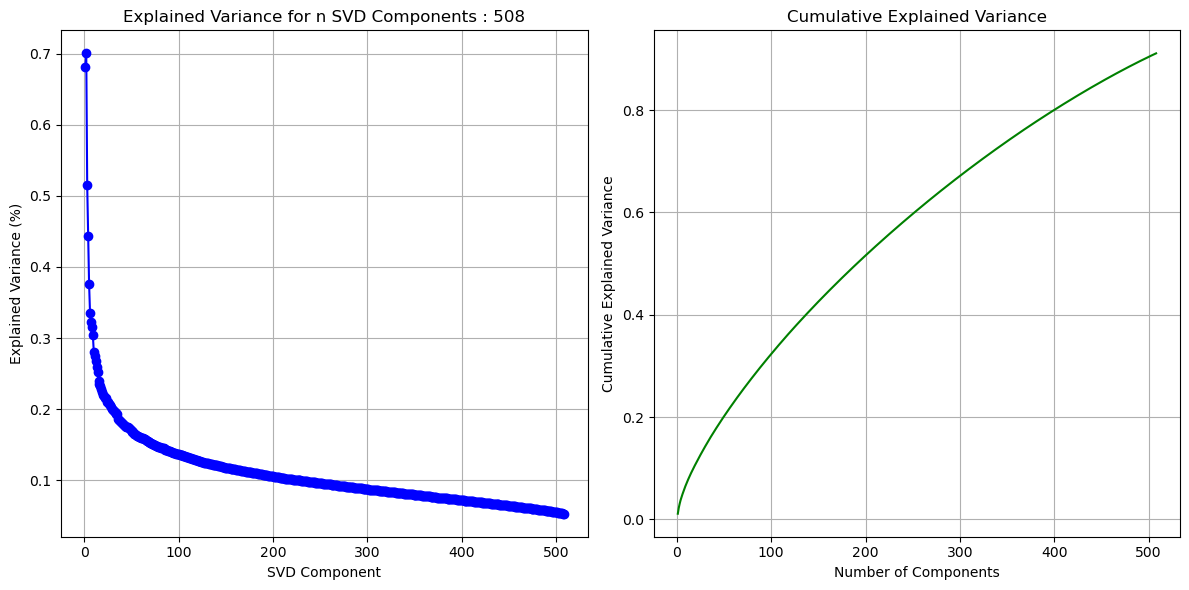

data shape : (996, 508)


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


13176
['0' '000' '02' ... 'zone' 'zones' 'zooms']
shape of dataframe :  (1043, 26)
Year :  2019


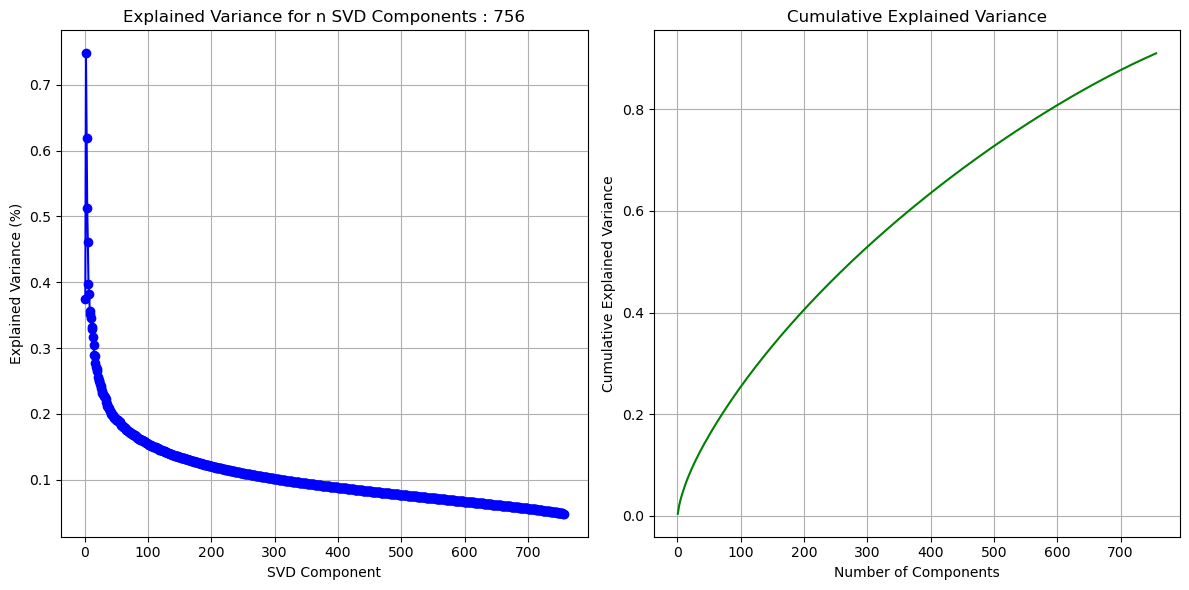

data shape : (1043, 756)


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


13937
['0' '000' '01' ... 'zooplankton' 'zoster' 'zurich']
shape of dataframe :  (1200, 26)
Year :  2020


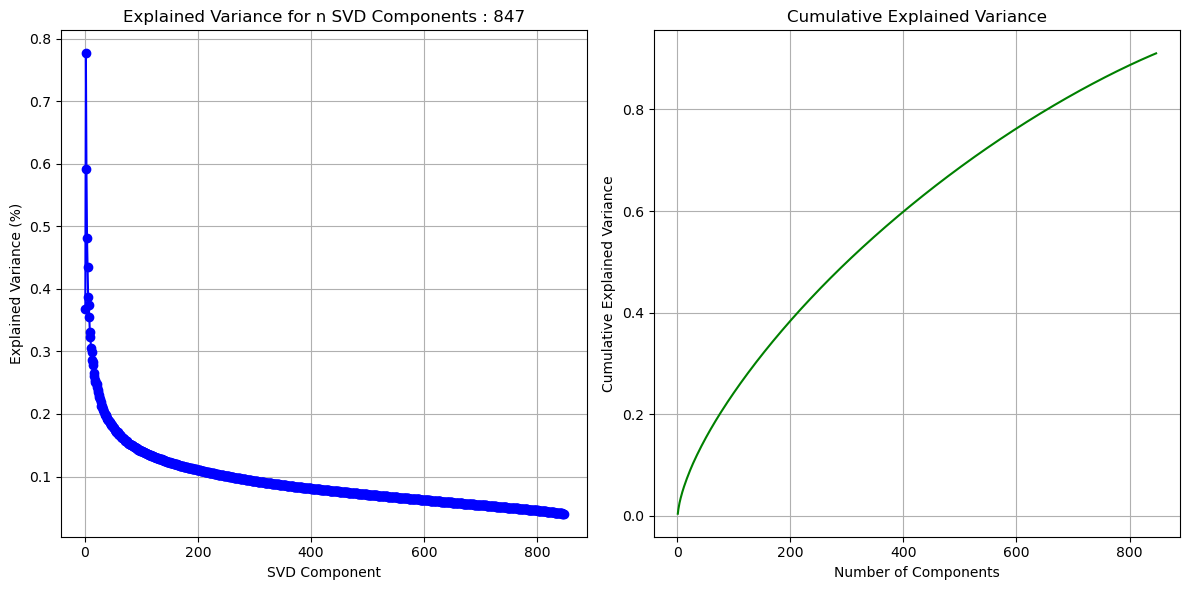

data shape : (1200, 847)


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


14462
['0' '000' '00000000000' ... 'zulu' 'zurich' 'zx']
shape of dataframe :  (1247, 26)
Year :  2021


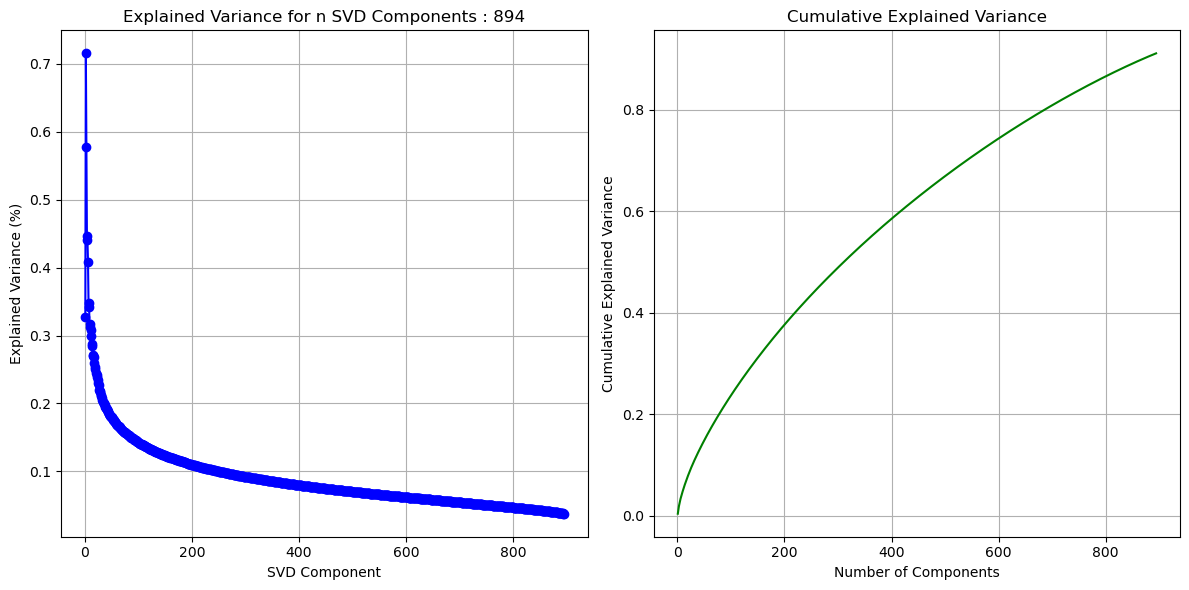

data shape : (1247, 894)


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


14284
['0' '00' '065' ... 'zygote' 'zygotic' 'zync']
shape of dataframe :  (1341, 26)
Year :  2022


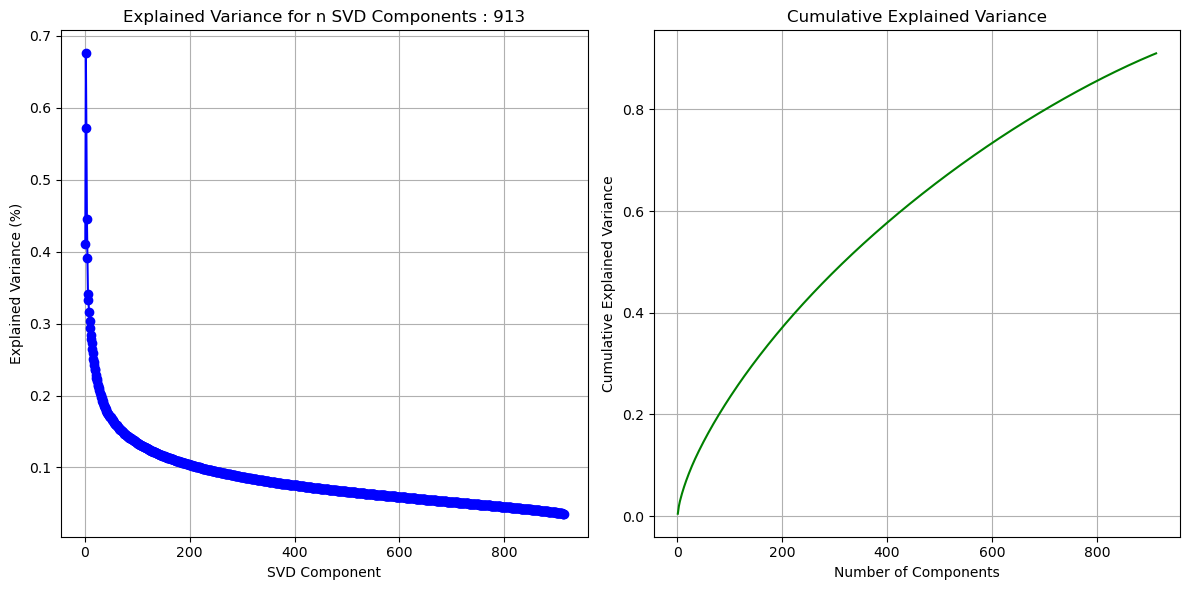

data shape : (1341, 913)


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


13952
['0' '0015' '0072' ... 'zoophysiology' 'zooplankton' 'zurich']
shape of dataframe :  (1437, 26)
Year :  2023


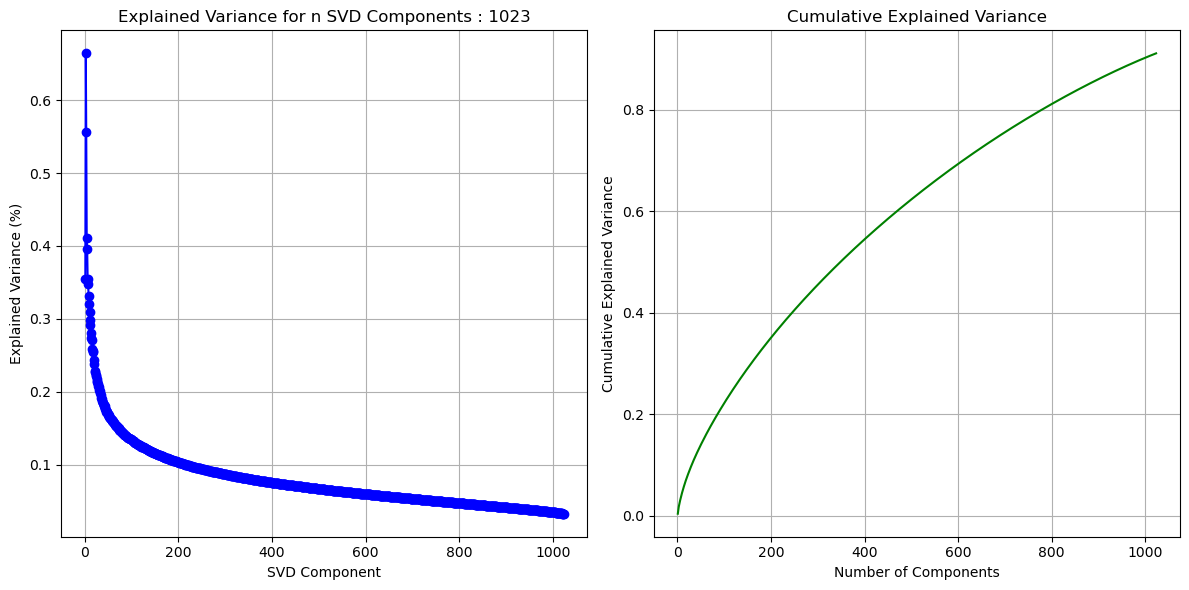

data shape : (1437, 1023)


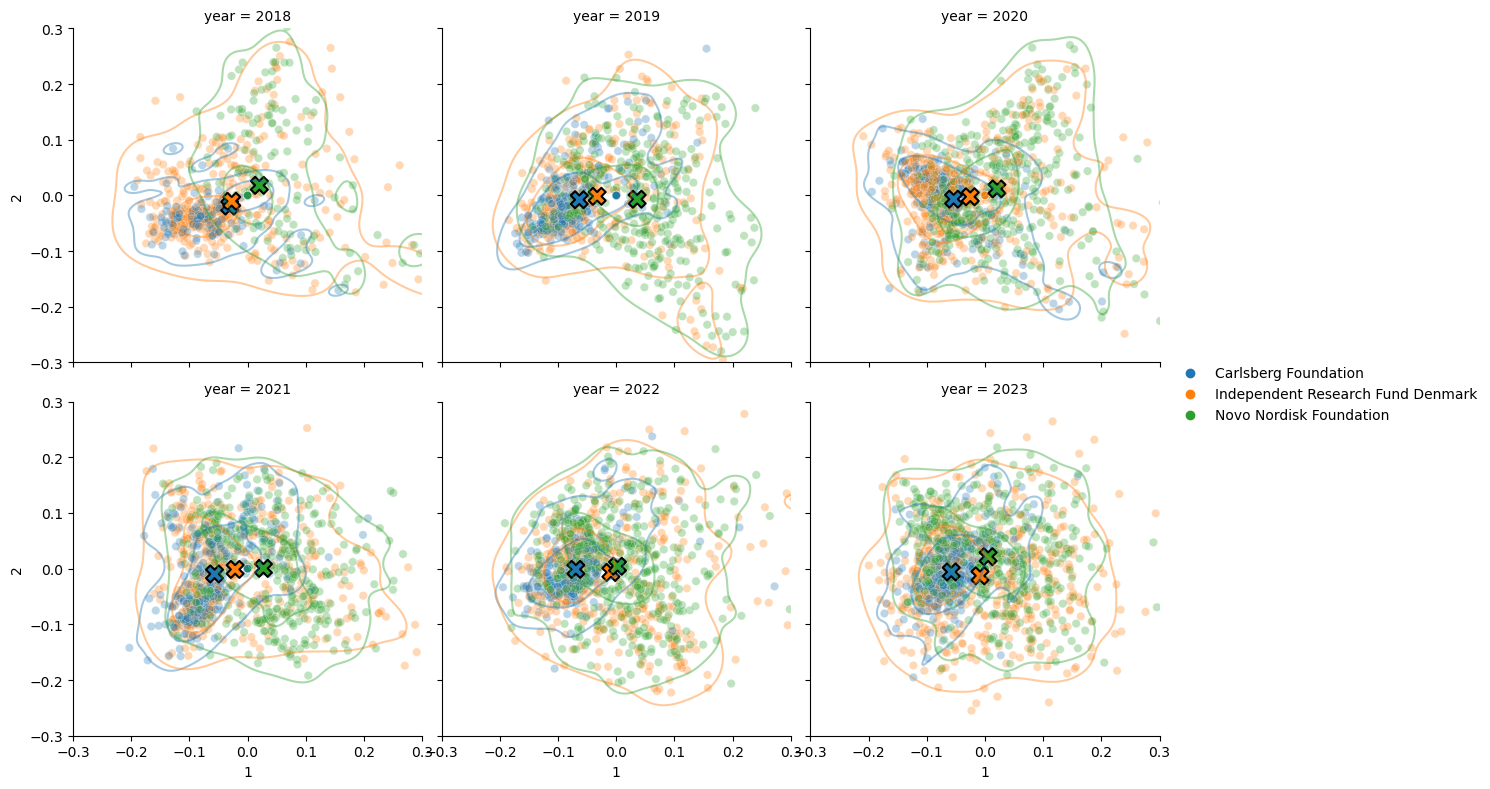

Version 2


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


35813
['0' '00' '000' ... 'zygote' 'zygotic' 'zync']
[(1066, 2061), (2062, 3104), (3105, 4304), (4305, 5551), (5552, 6892), (6893, 8329)]
2018


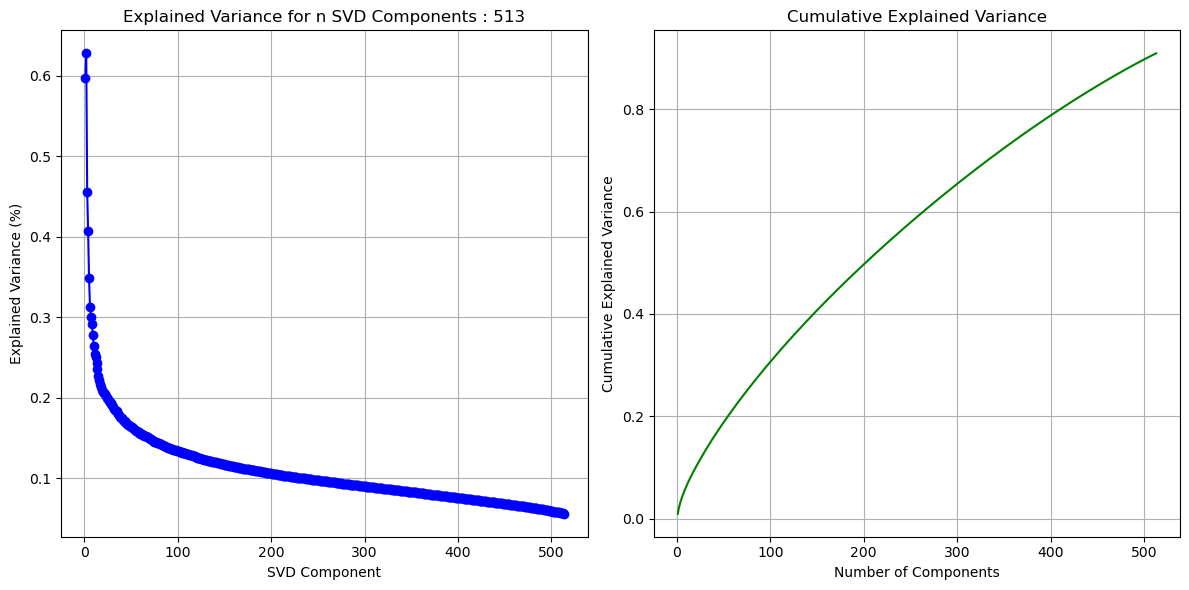

2019


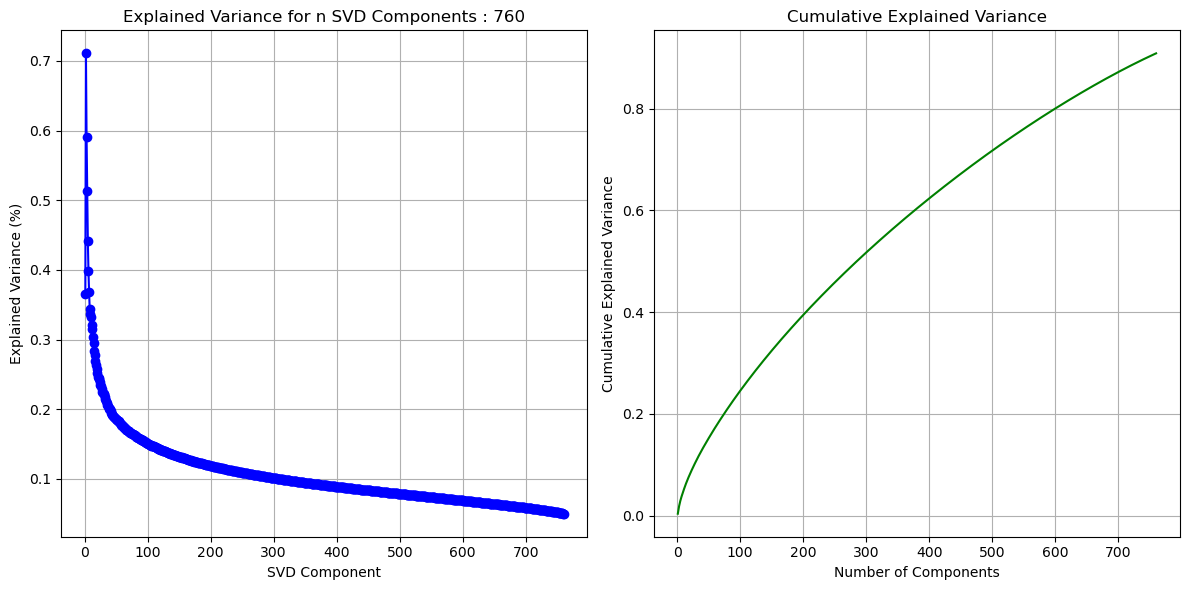

2020


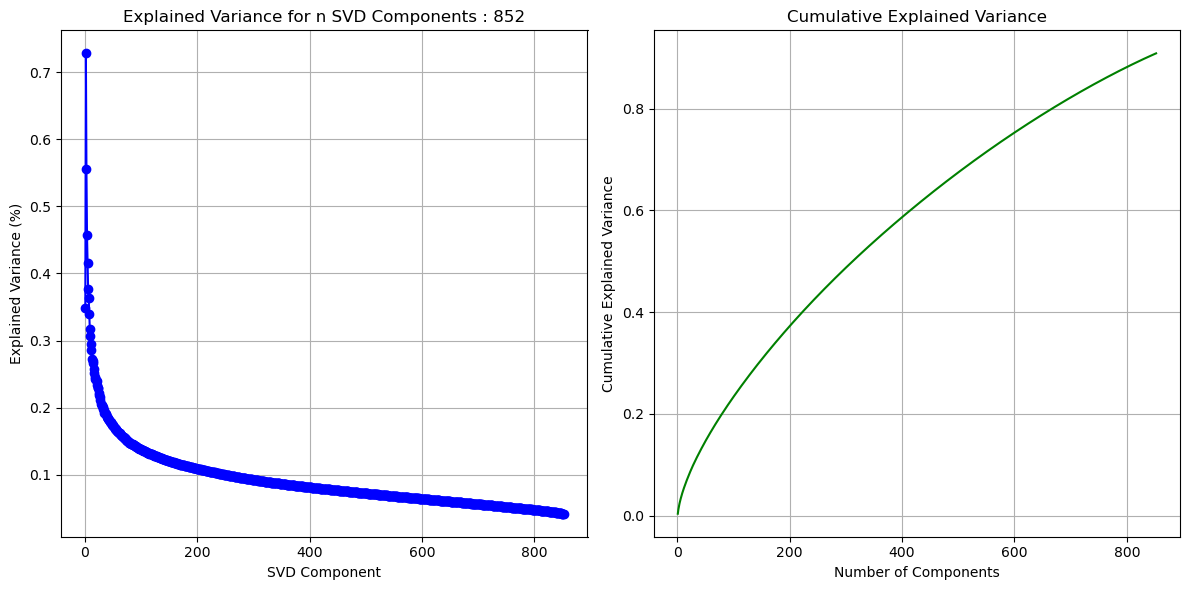

2021


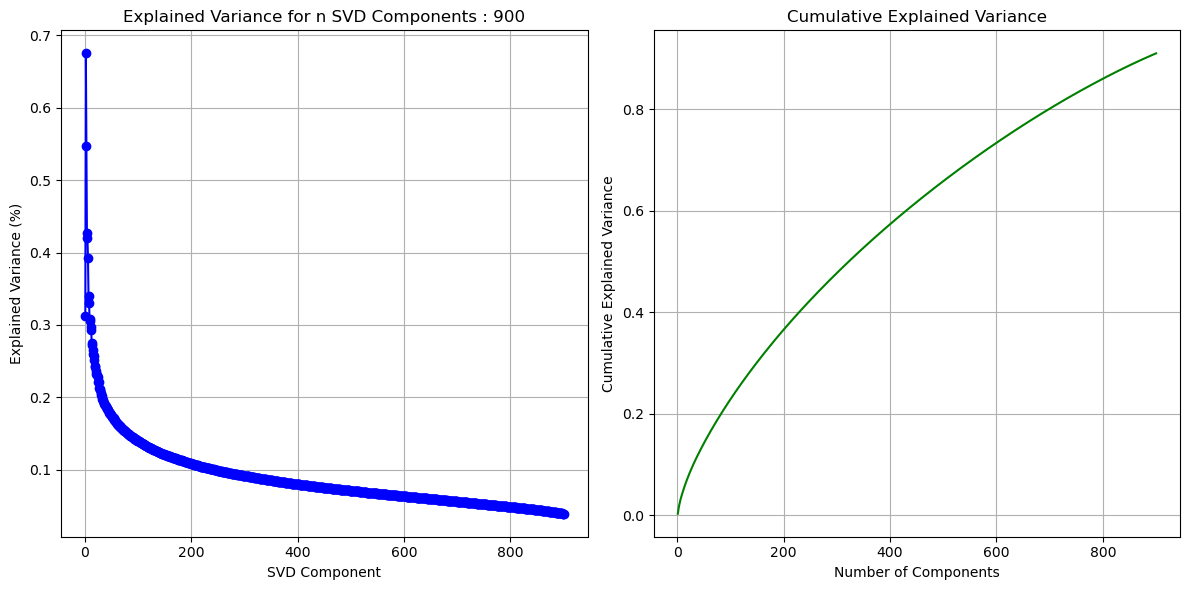

2022


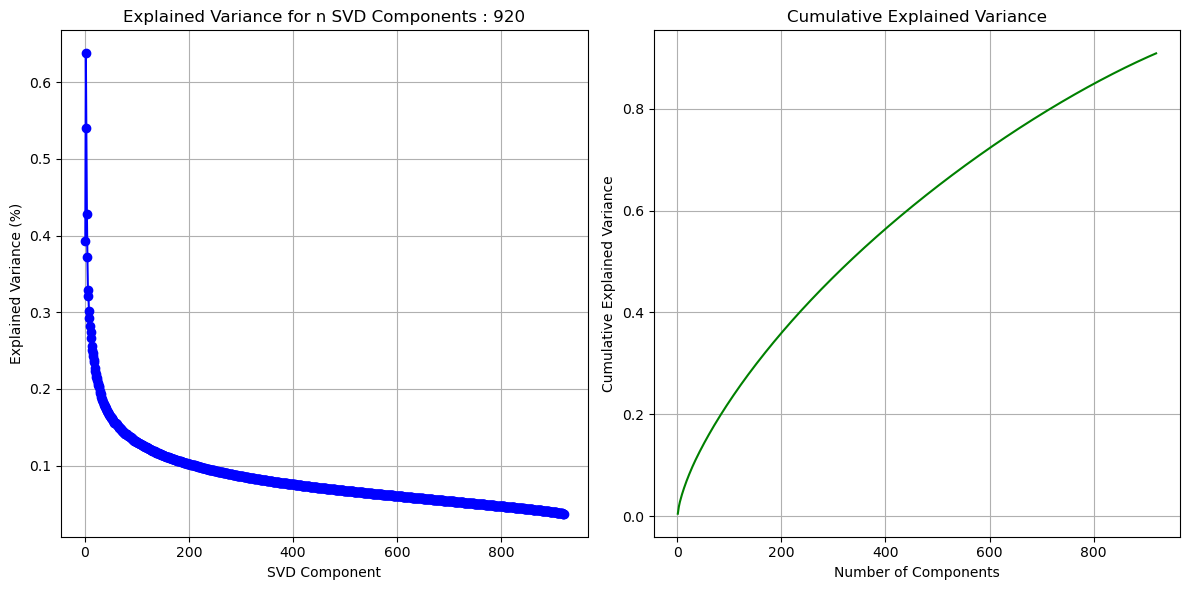

2023


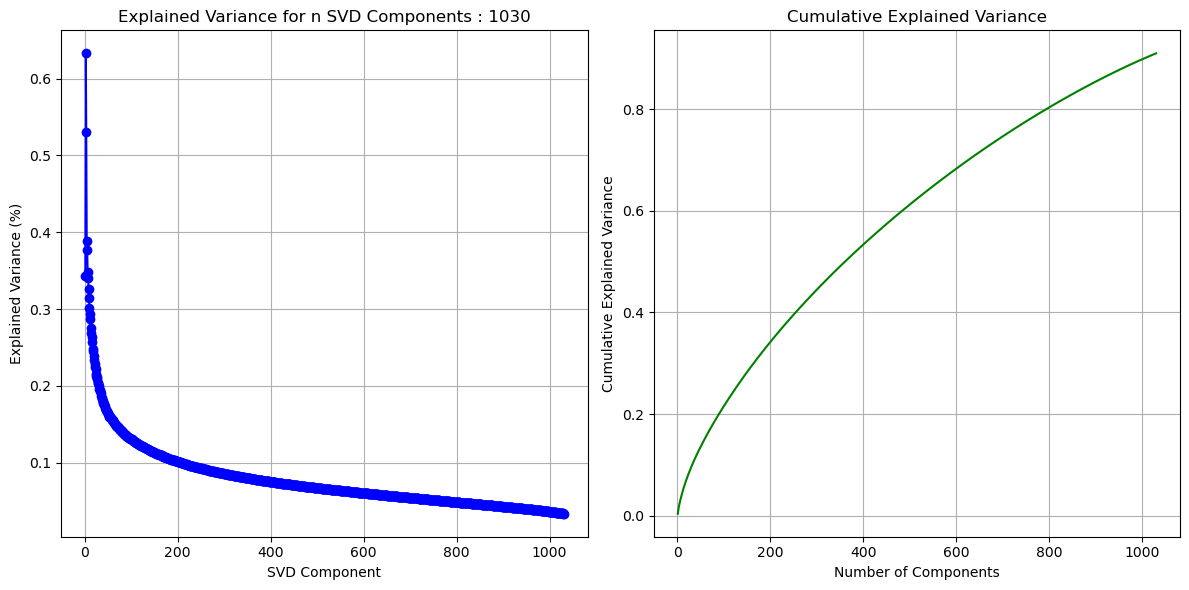

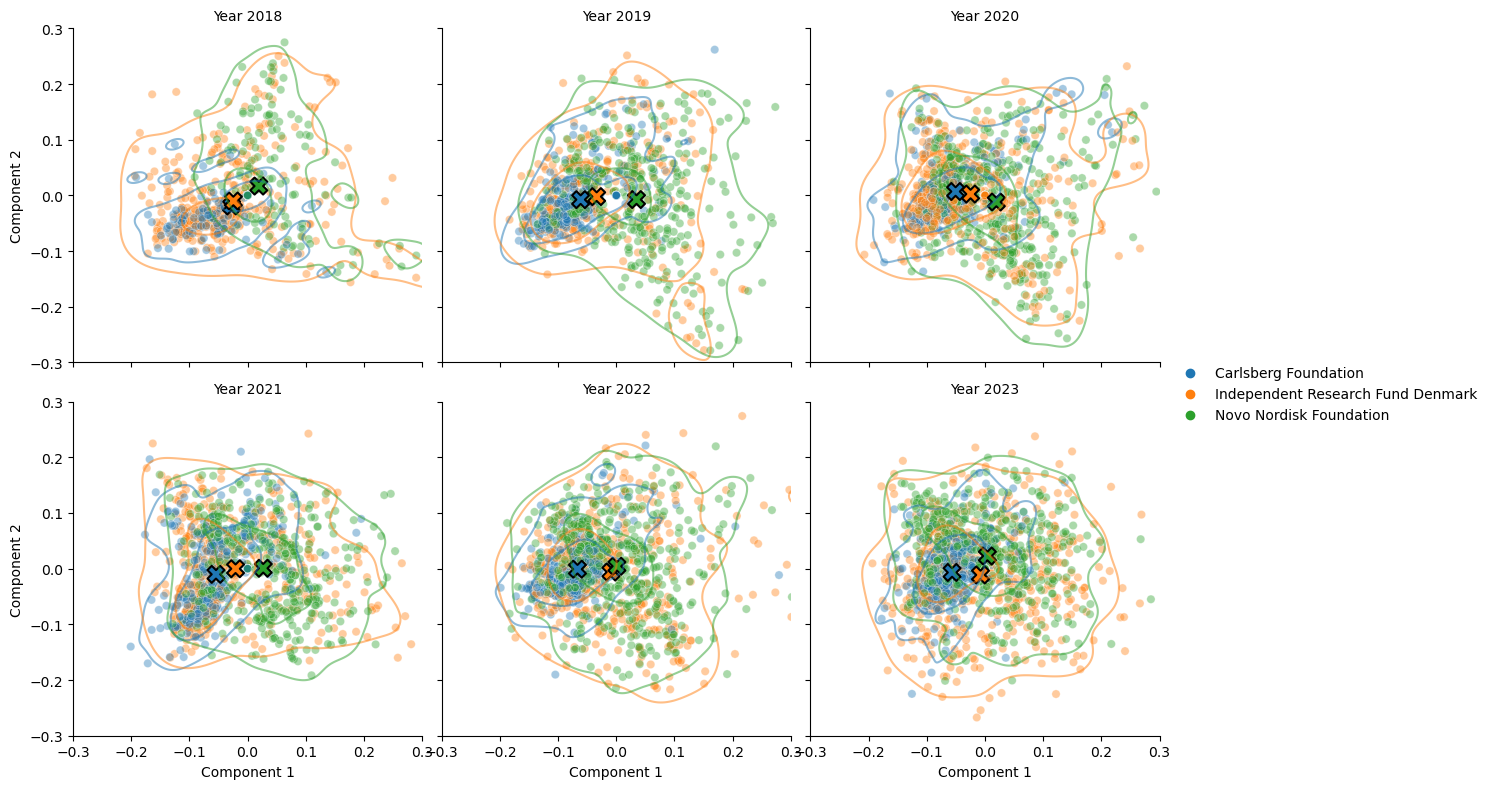

Foundation : Carlsberg Foundation


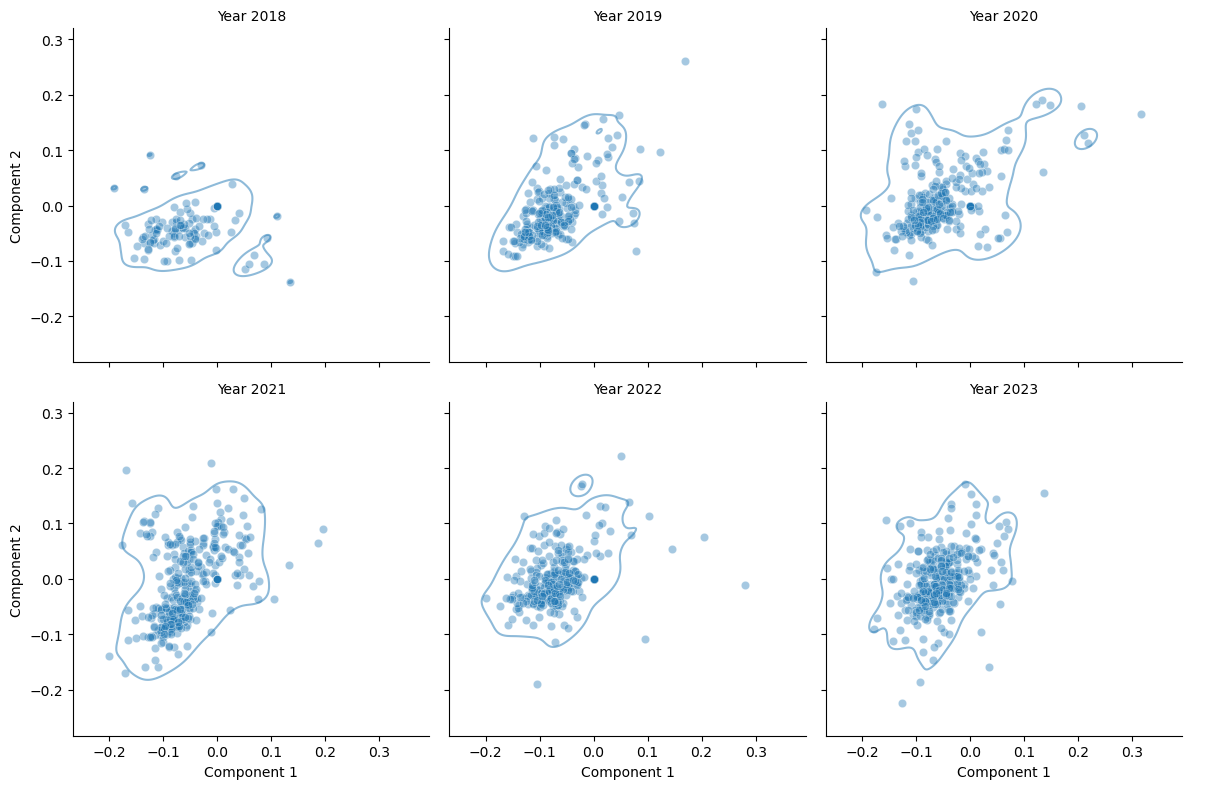

Foundation : Independent Research Fund Denmark


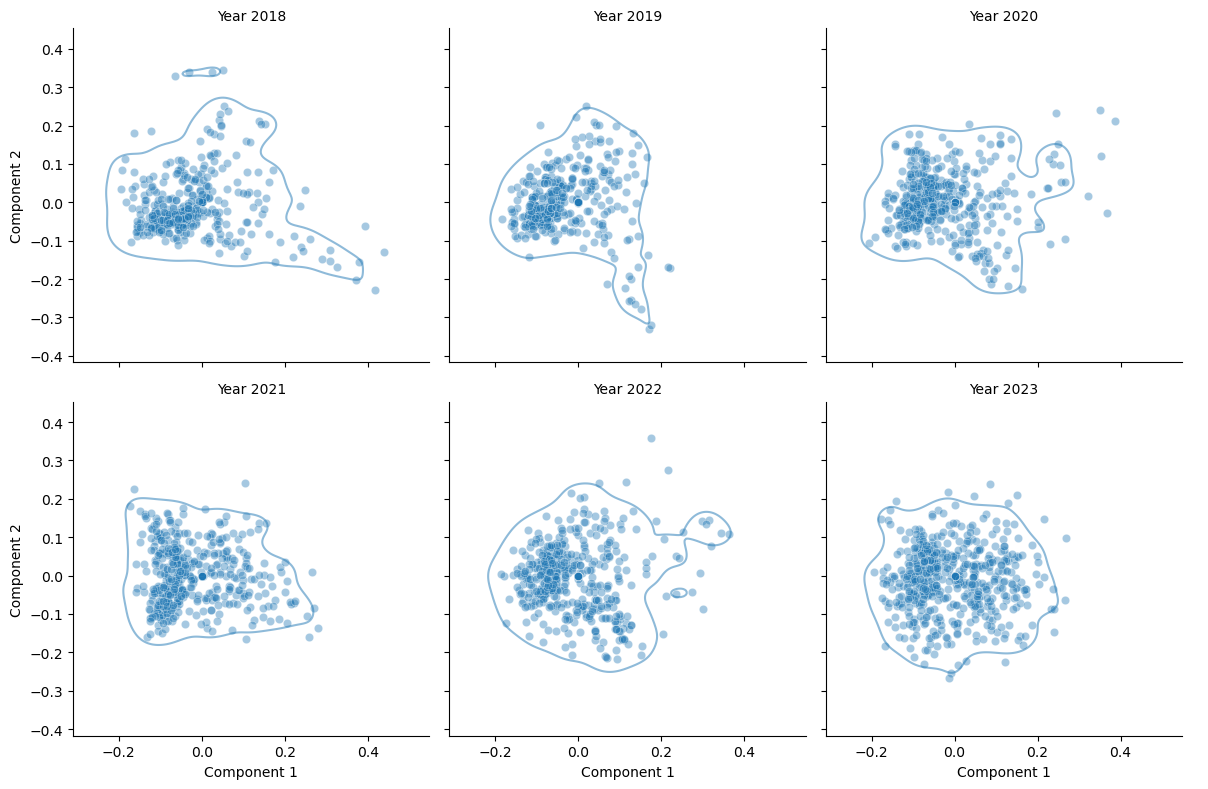

Foundation : Novo Nordisk Foundation


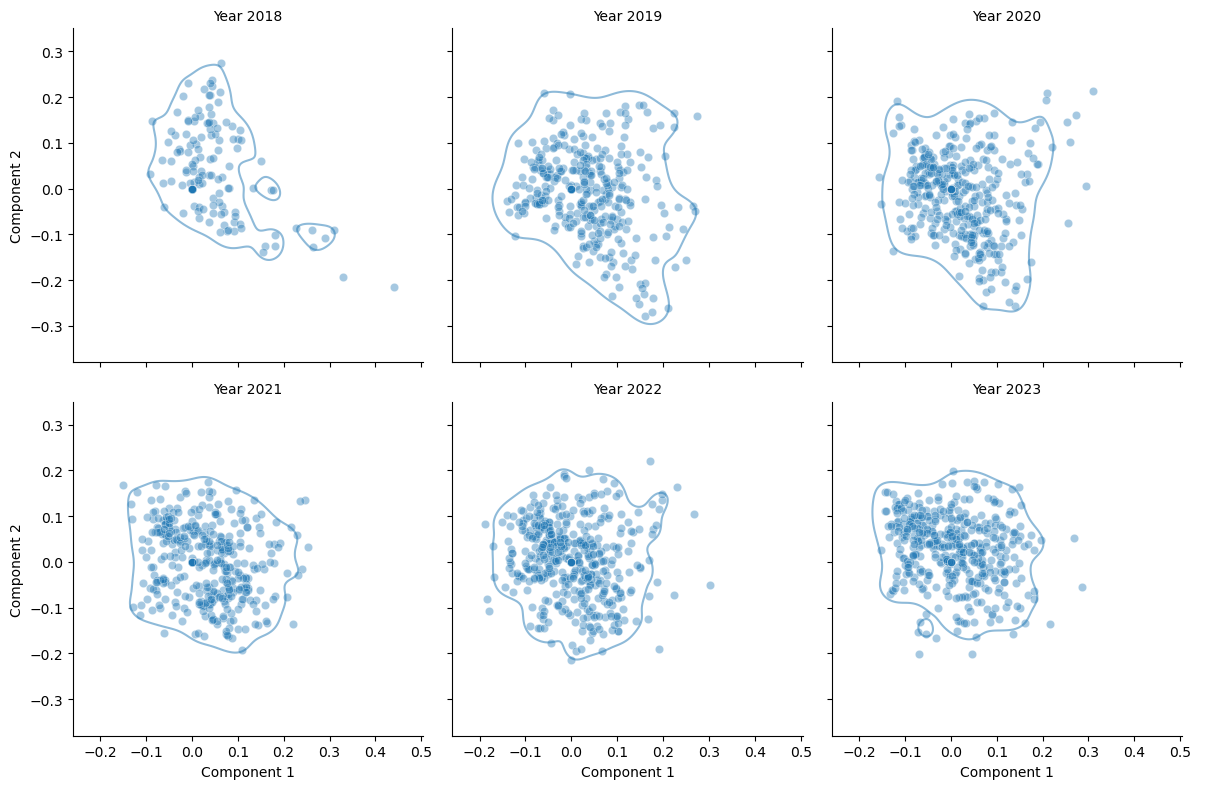

In [307]:

#calling 1

df_clean["abstract_no_nan"] = df_clean.cleaned_column.fillna('')

print("Version 1")
fun_call_v1(df_clean, l1) #version 1 -> reset every year, calculate TF-IDF individual for each year

print("Version 2")
fun_call_v2(df_clean, l2) #version 2 -> make tf_idf with all data and then iterate over the years 




Version 1


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


10828
['0' '00005' '005' ... 'zone' 'zones' 'zurich']
shape of dataframe :  (996, 26)
Year :  2018


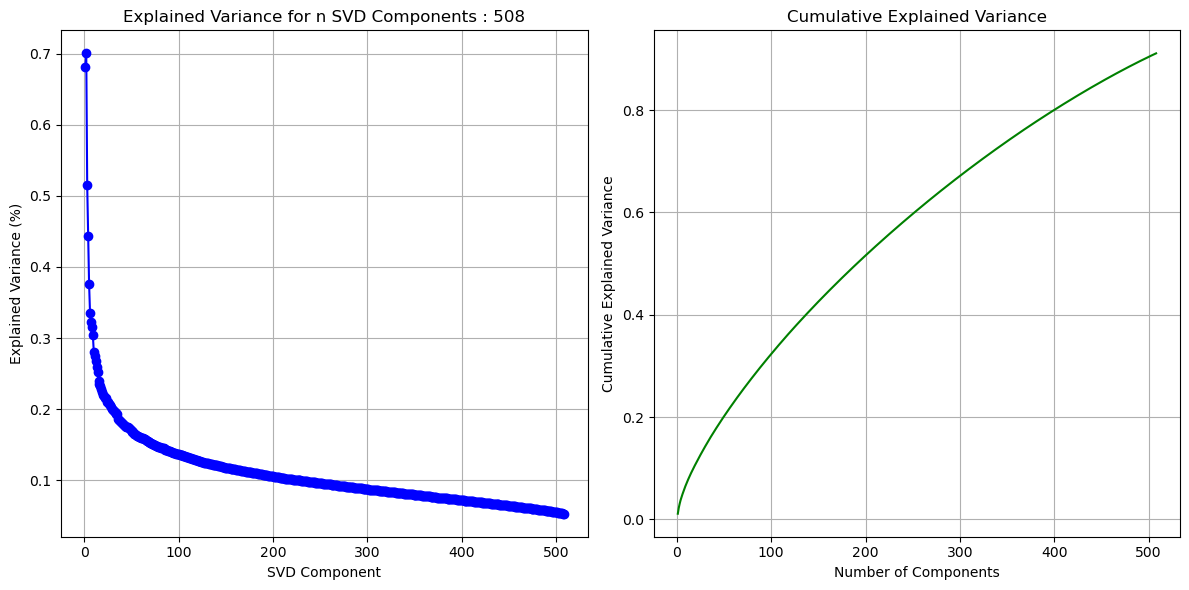

data shape : (996, 508)


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


13176
['0' '000' '02' ... 'zone' 'zones' 'zooms']
shape of dataframe :  (1043, 26)
Year :  2019


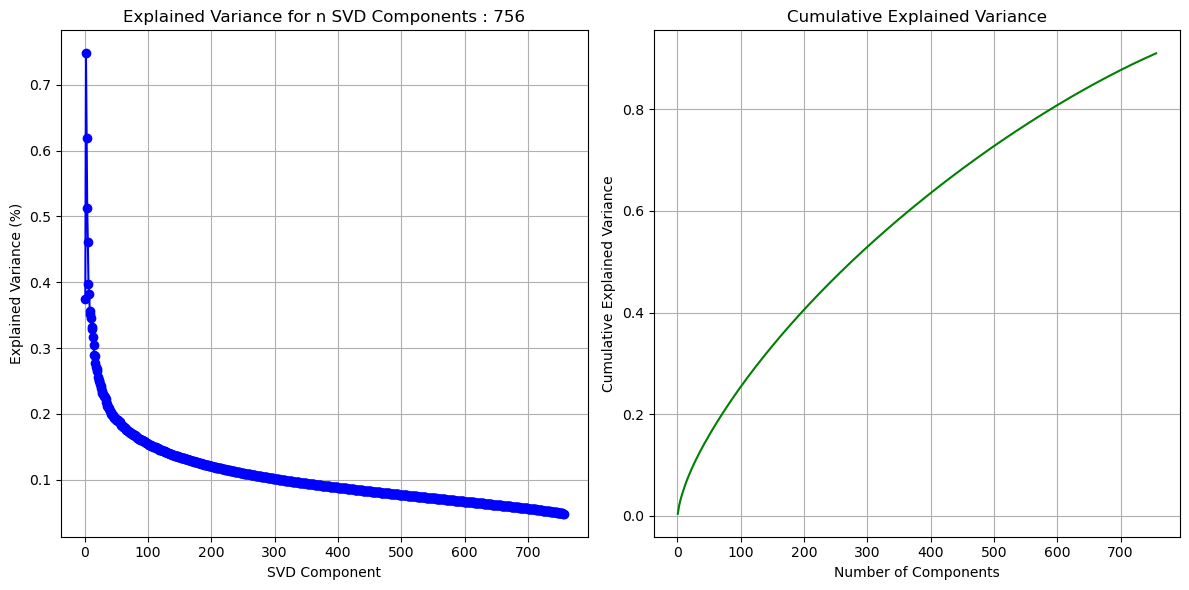

data shape : (1043, 756)


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


13937
['0' '000' '01' ... 'zooplankton' 'zoster' 'zurich']
shape of dataframe :  (1200, 26)
Year :  2020


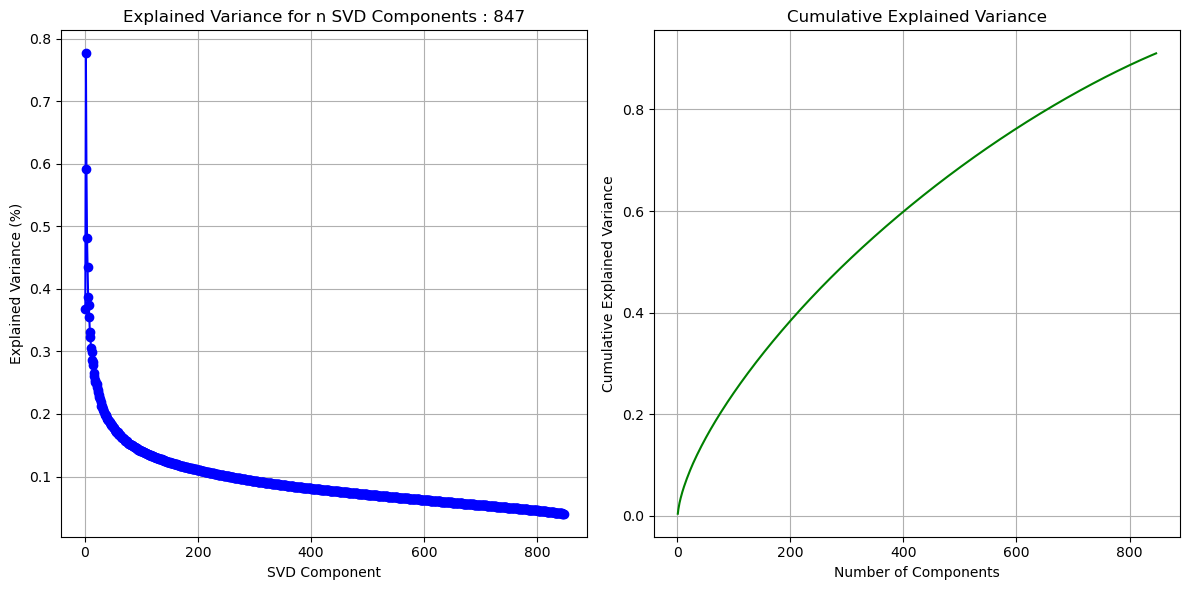

data shape : (1200, 847)


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


14462
['0' '000' '00000000000' ... 'zulu' 'zurich' 'zx']
shape of dataframe :  (1247, 26)
Year :  2021


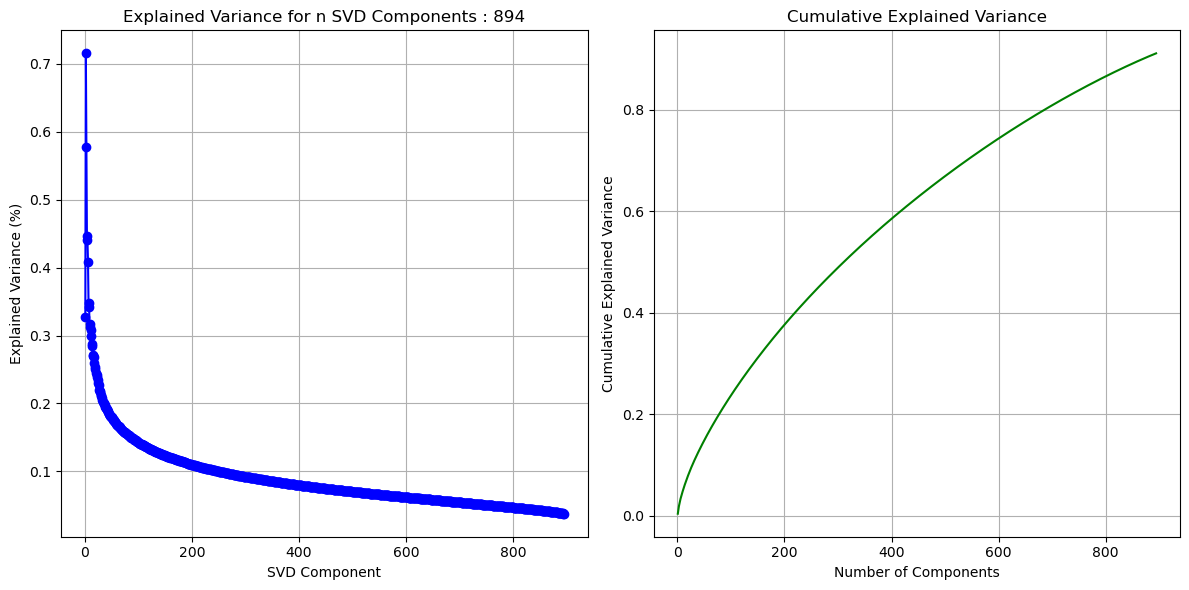

data shape : (1247, 894)


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


14284
['0' '00' '065' ... 'zygote' 'zygotic' 'zync']
shape of dataframe :  (1341, 26)
Year :  2022


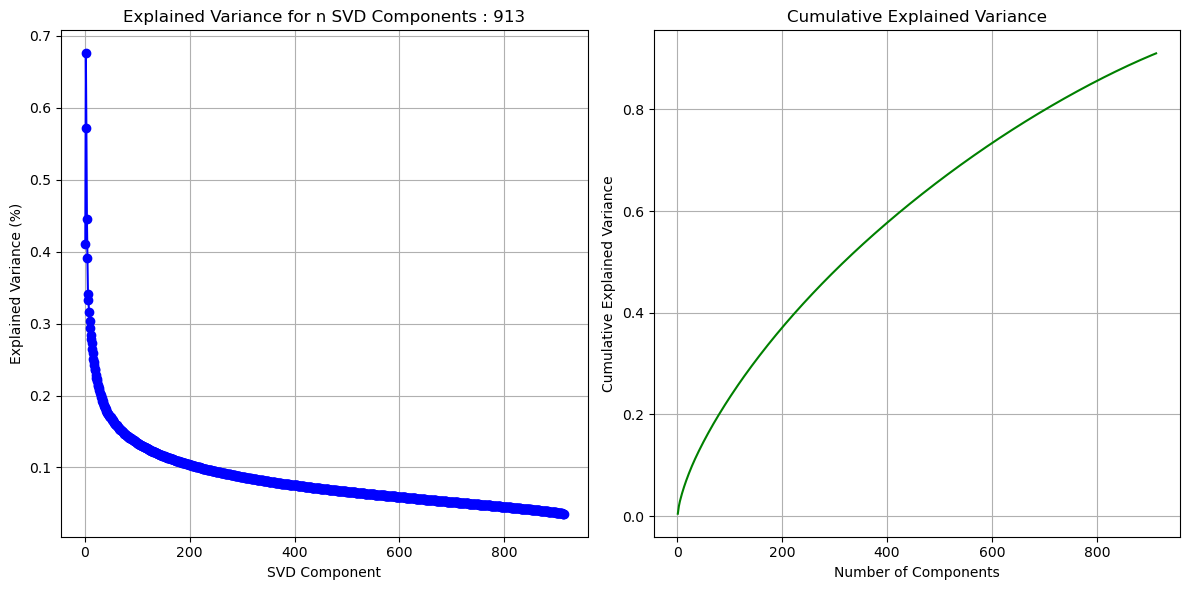

data shape : (1341, 913)


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


13952
['0' '0015' '0072' ... 'zoophysiology' 'zooplankton' 'zurich']
shape of dataframe :  (1437, 26)
Year :  2023


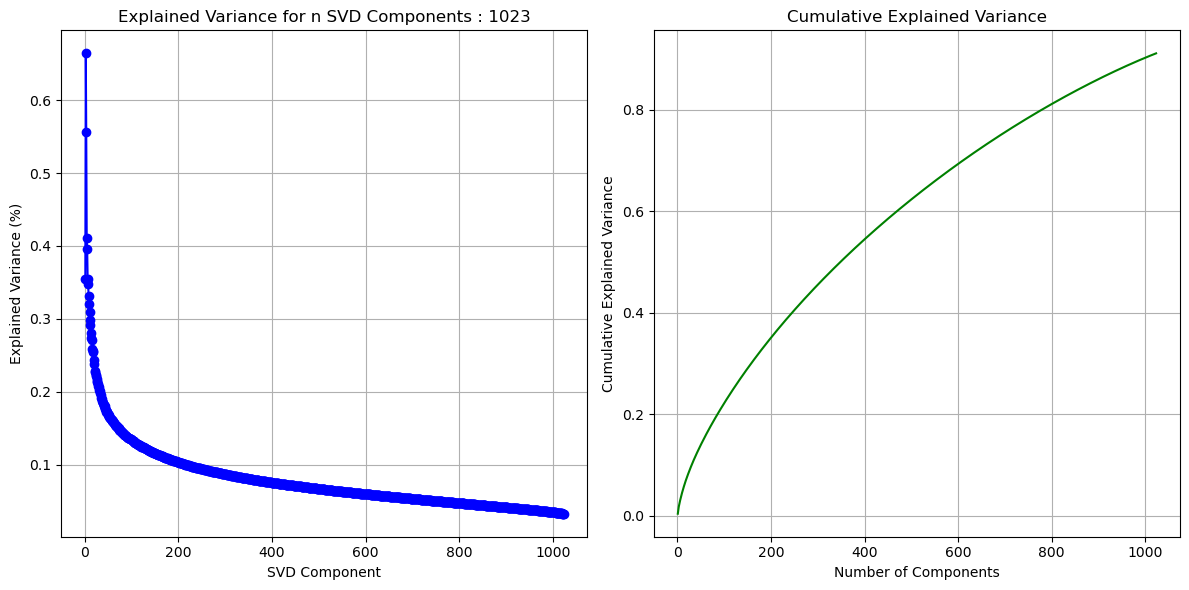

data shape : (1437, 1023)


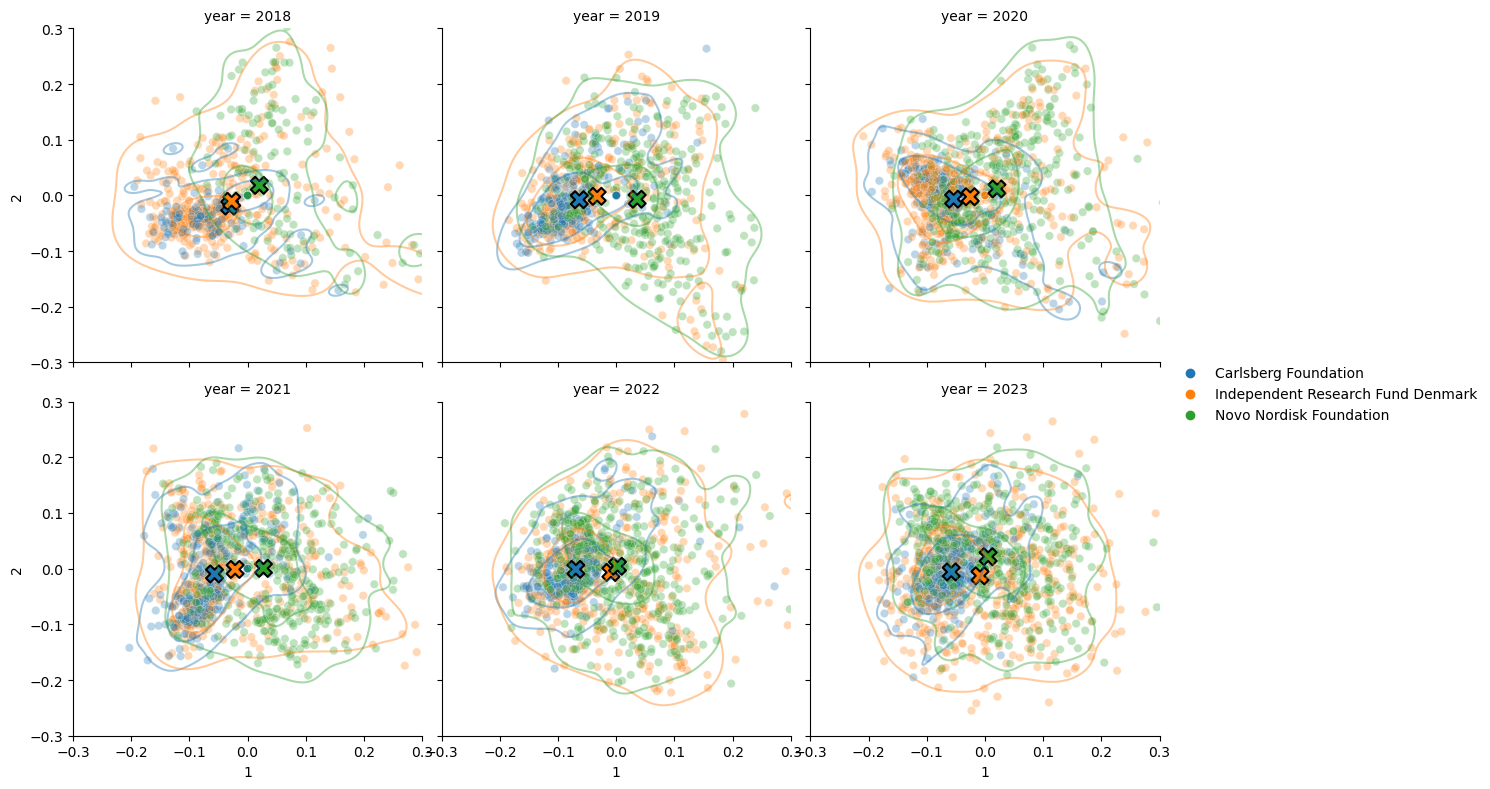

Version 2


/Users/macbook/.conda/envs/untitled/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


35813
['0' '00' '000' ... 'zygote' 'zygotic' 'zync']
[(1066, 2061), (2062, 3104), (3105, 4304), (4305, 5551), (5552, 6892), (6893, 8329)]
2018


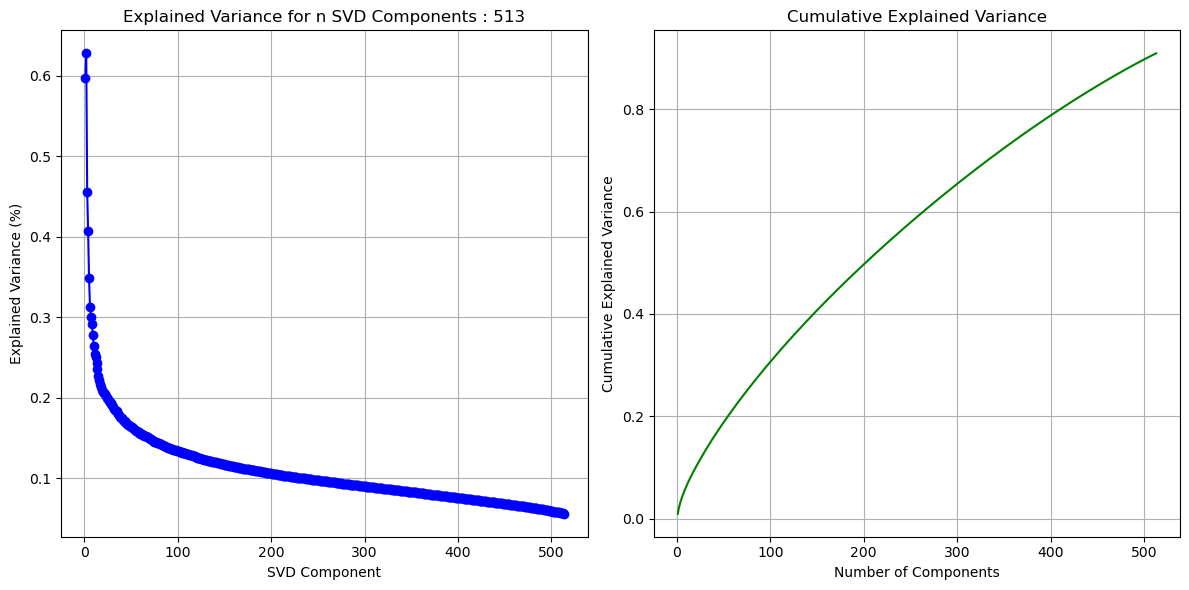

2019


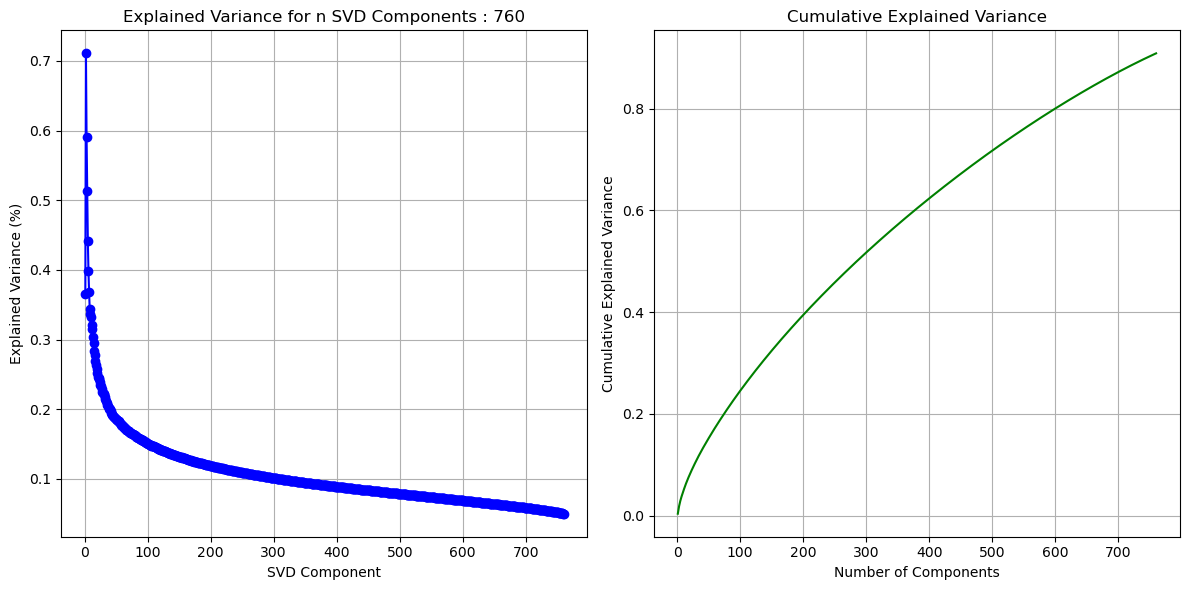

2020


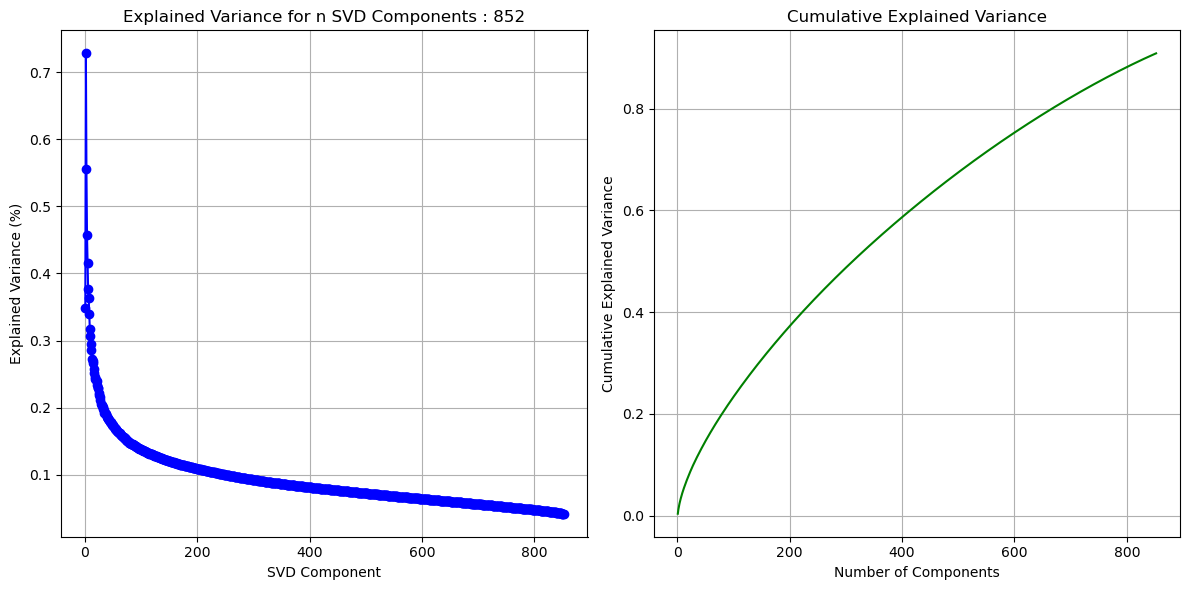

2021


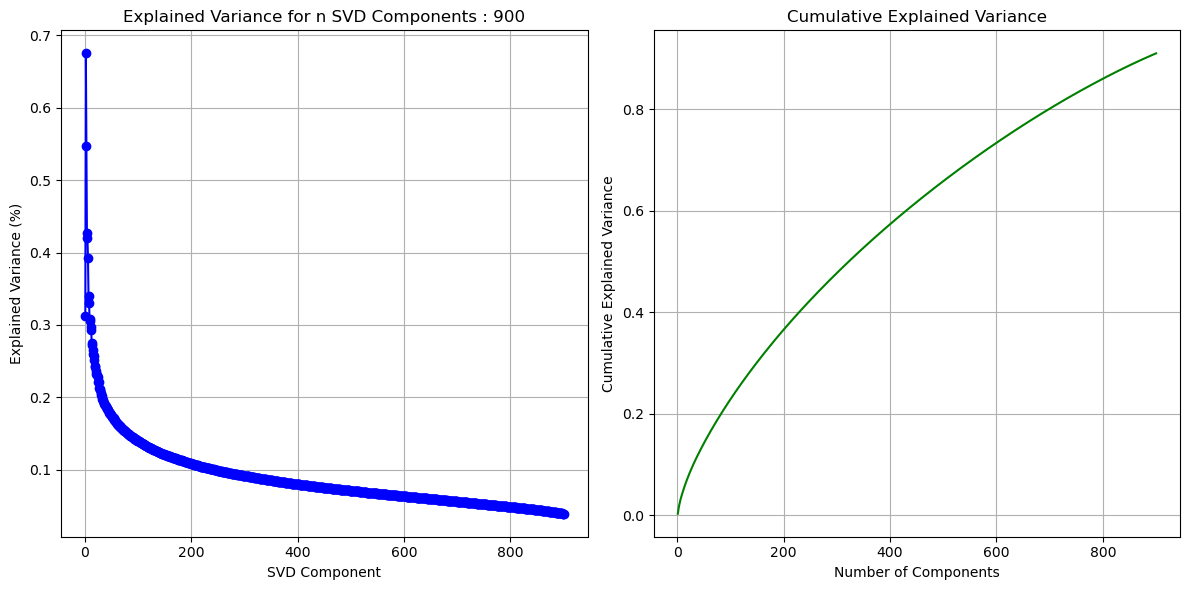

2022


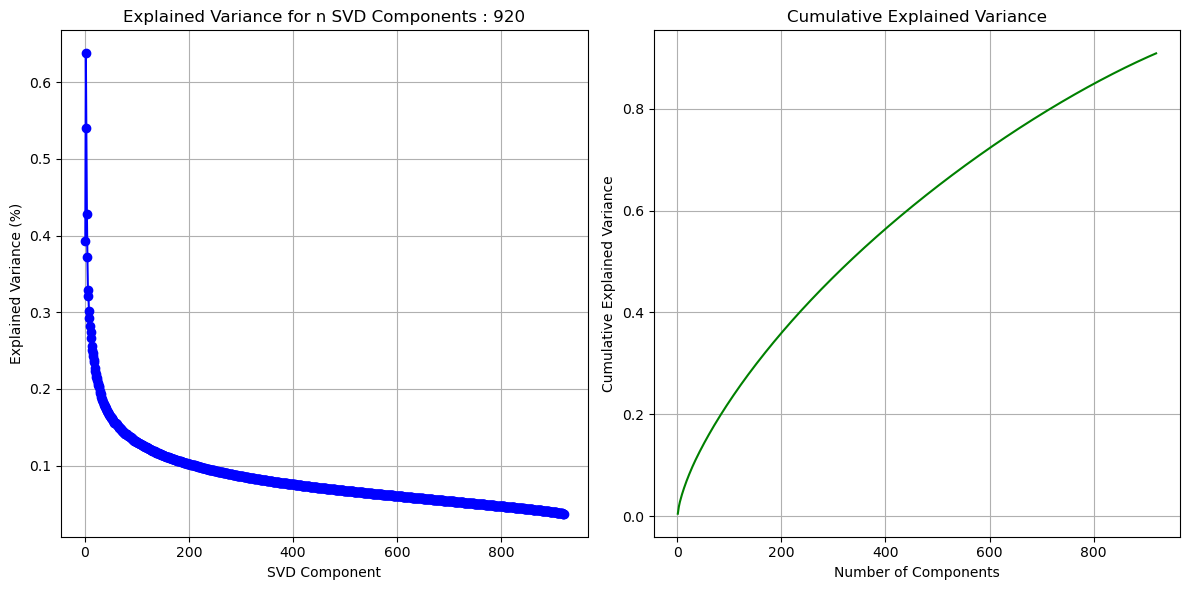

2023


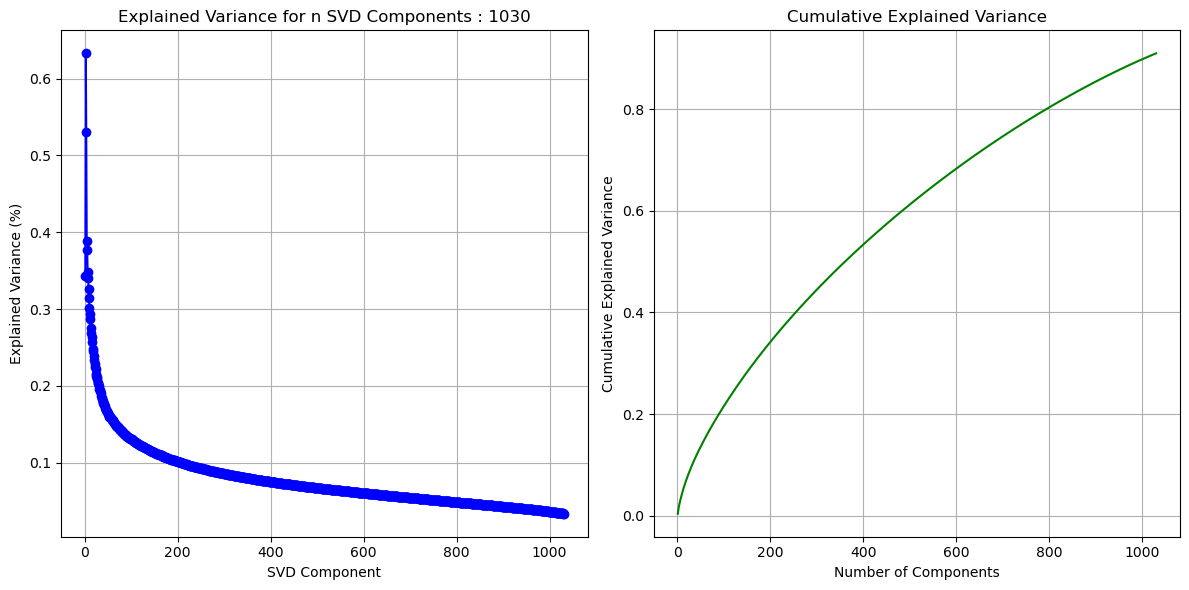

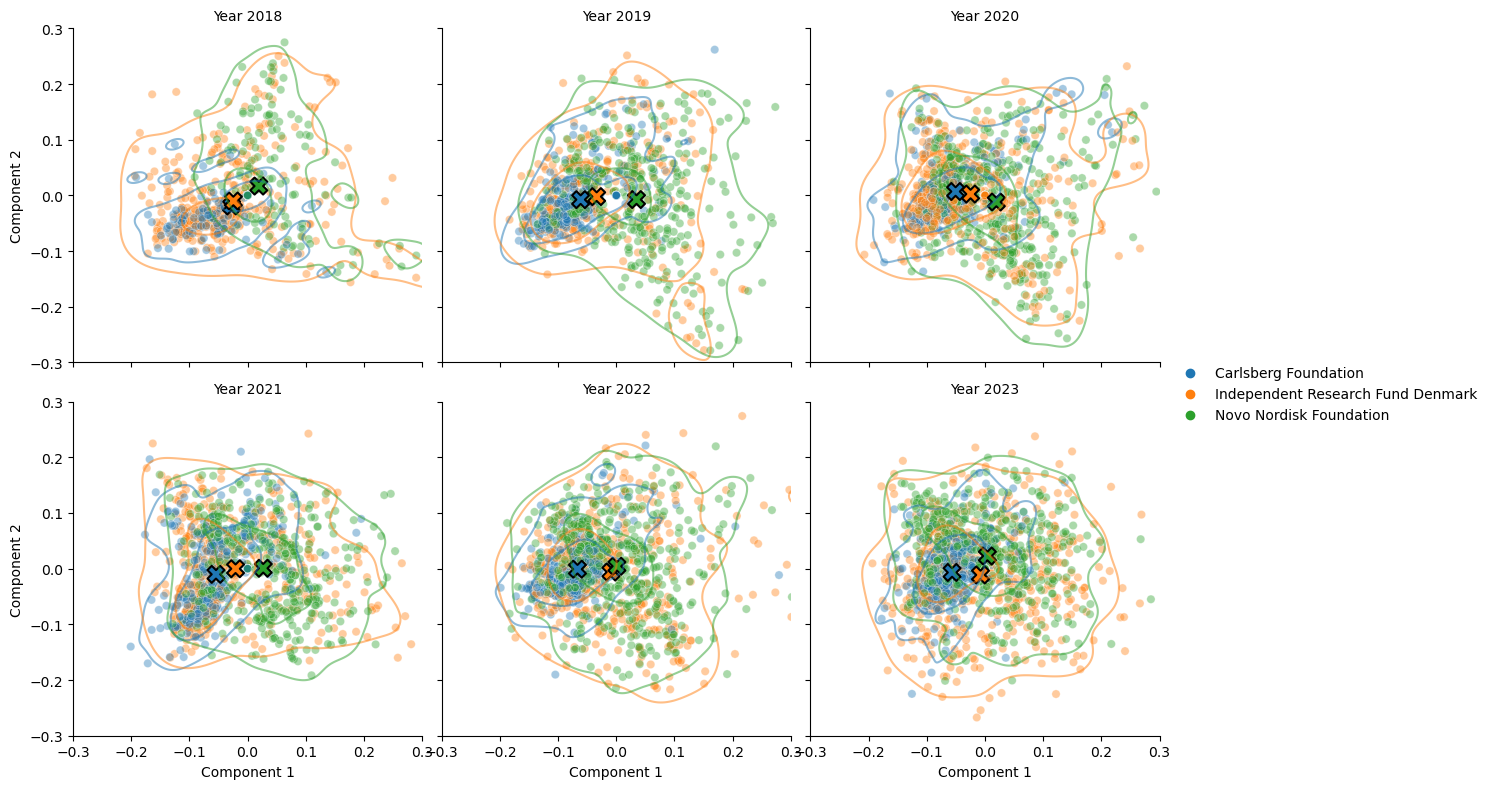

Foundation : Carlsberg Foundation


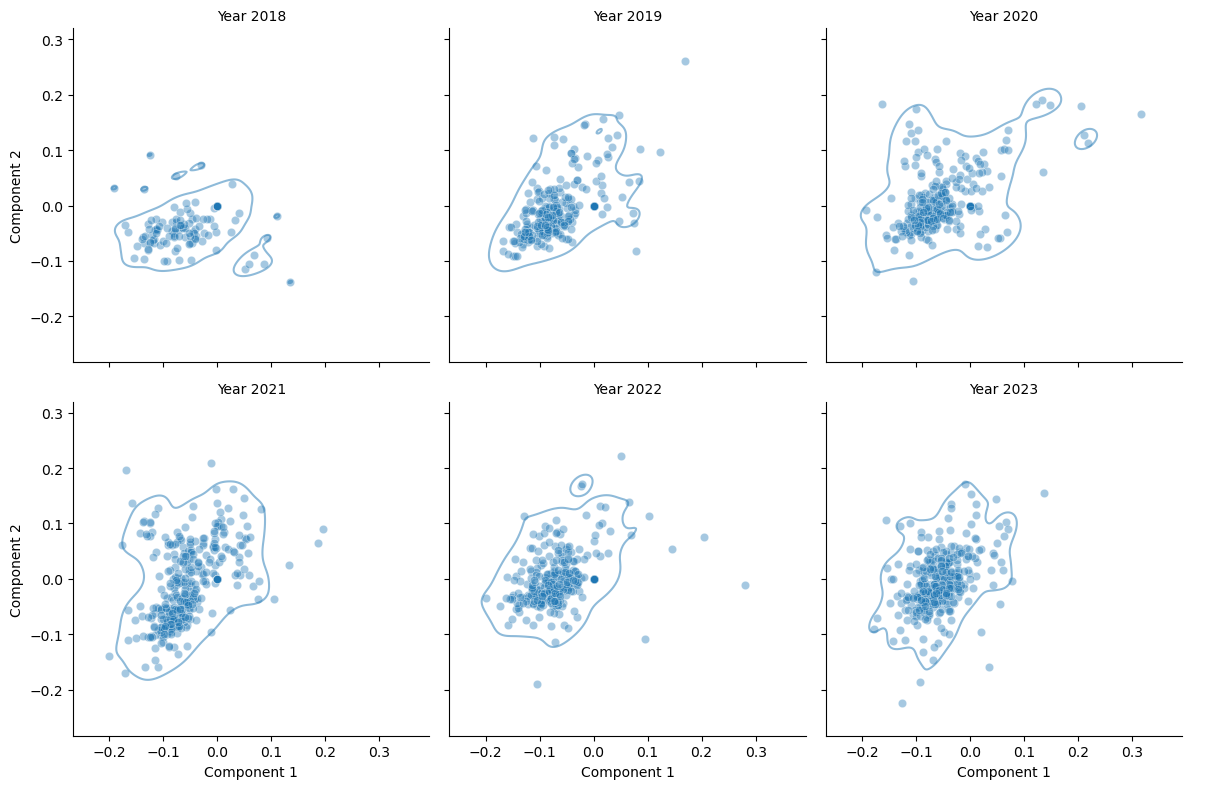

Foundation : Independent Research Fund Denmark


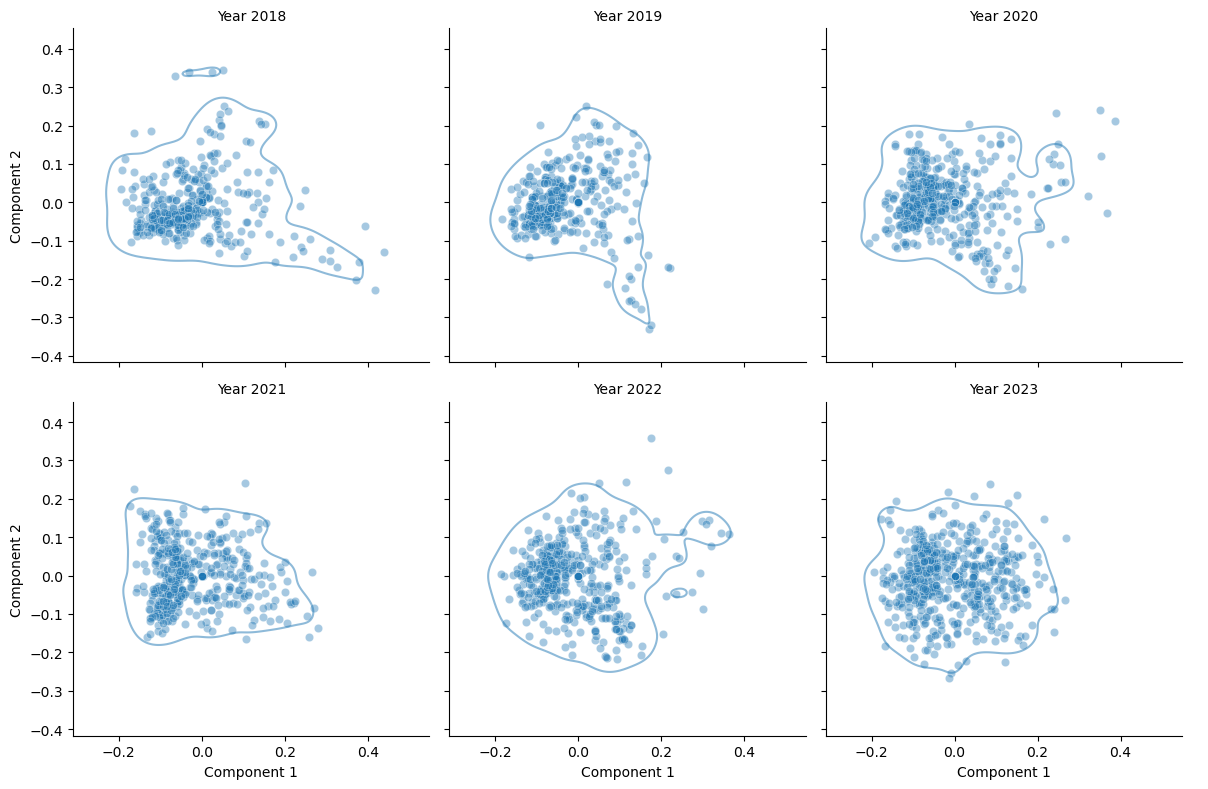

Foundation : Novo Nordisk Foundation


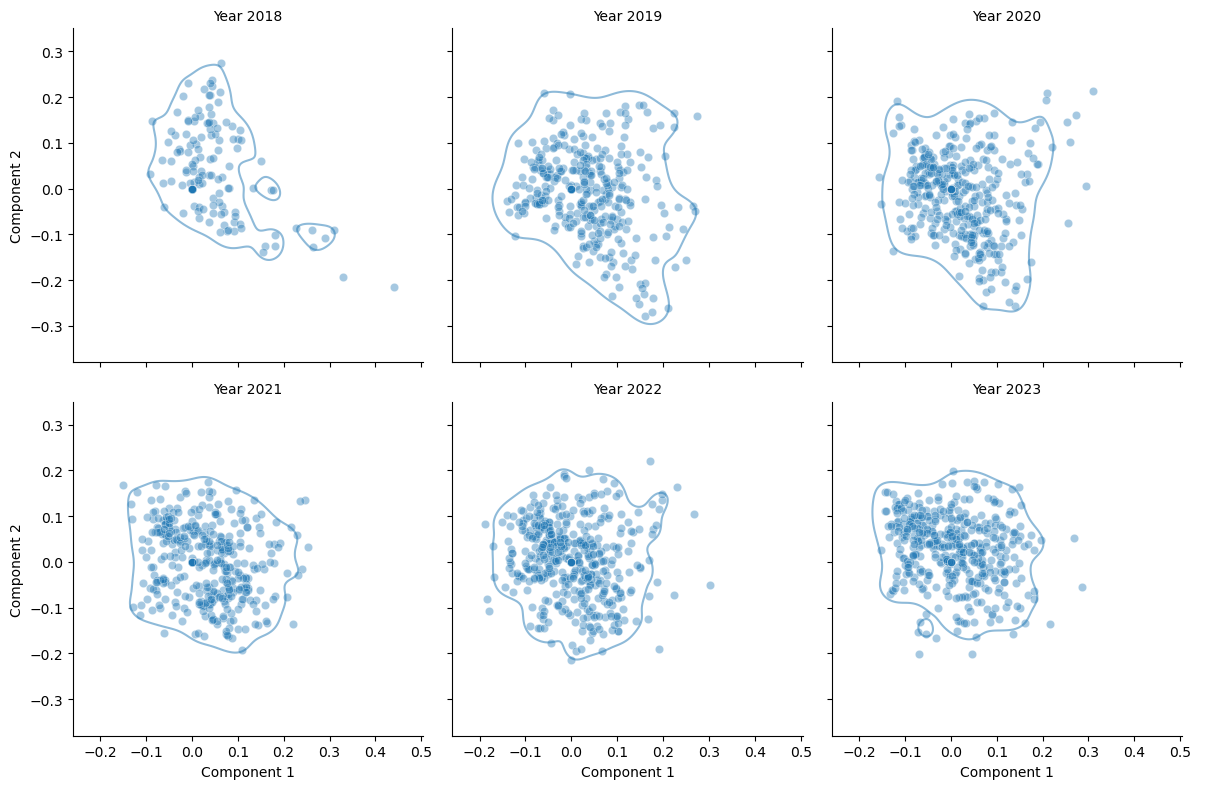

In [29]:
#version - data cleanse with no stemming
df_clean_no_stem["abstract_no_nan"] = df_clean.cleaned_column.fillna('')
print("Version 1")
fun_call_v1(df_clean_no_stem, l1) #version 1 -> reset every year, calculate TF-IDF individual for each year

print("Version 2")
fun_call_v2(df_clean_no_stem, l2)


In [ ]:
#Cosine distance between individual fund and it's mean in that year -> comparing variance

In [ ]:
#cosine distance vs. eucledian -> control for differences in lengths -> can compare 